In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

To Do: Implement TPU acceleration

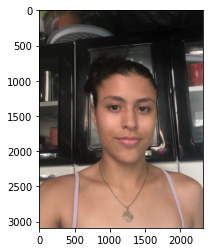

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('../input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_9.jpg')
imgplot = plt.imshow(img)

In [3]:
img.shape

(3088, 2320, 3)

In [4]:
images = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images,columns=['filenames'])

In [5]:
images['given_names'] = images.filenames.apply(lambda x: x[x.find('name')+5:x.find('/',x.find('name')+5)])

In [6]:
images["image_type"] = images.filenames.apply(lambda x: x[x.find('/',x.find('name')+5)+1:x.find('_',x.find('name')+5)])

In [7]:
images = images[2:].reset_index(drop=True)

In [8]:
images

,filenames,given_names,image_type
0,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
1,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
2,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
3,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
4,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
...,...,...,...
428,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
429,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
430,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
431,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie


In [9]:
def build_facematch_dataset(images):
    X1_dataset = []
    X2_dataset = []
    y1_dataset = []
    y2_dataset = []
    for i in range(len(images)-2):
        X1_dataset.append(images.filenames[i])
        X2_dataset.append(images.filenames[i+1])
        if images.given_names[i] == images.given_names[i+1]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[i] == 'ID' and images.image_type[i+1] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
    for i in range(len(images)):
        first_sample = np.random.randint(0,len(images))
        second_sample = np.random.randint(0,len(images))
        X1_dataset.append(images.filenames[first_sample])
        X2_dataset.append(images.filenames[second_sample])
        if images.given_names[first_sample] == images.given_names[second_sample]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[first_sample] == 'ID' and images.image_type[second_sample] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
        
    return tf.data.Dataset.from_tensor_slices(({"input_1":X1_dataset,"input_2":X2_dataset},
                                               {"facematch":y1_dataset,"liveness":y2_dataset}))

In [10]:
dataset = build_facematch_dataset(images)

2022-10-30 19:14:44.319564: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=864>

In [12]:
for i in dataset.take(1):
    print(i)

({'input_1': <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus /Selfie_2.jpg'>, 'input_2': <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af8d2aad9d9c12b4864776_age_23_name_Matheus /ID_2.jpg'>}, {'facematch': <tf.Tensor: shape=(), dtype=int32, numpy=1>, 'liveness': <tf.Tensor: shape=(), dtype=int32, numpy=1>})


In [13]:
def process_path(images,labels):
    image_size = [56,56]
    raw1, raw2 = tf.io.read_file(images["input_1"]), tf.io.read_file(images["input_2"])
    image1, image2 = tf.io.decode_jpeg(raw1, channels=3), tf.io.decode_jpeg(raw2, channels=3)
    image1, image2 = tf.image.resize(image1, image_size), tf.image.resize(image2, image_size)
    image1 = (image1 - tf.reduce_mean(image1))/tf.math.reduce_std(image1)
    image2 = (image2 - tf.reduce_mean(image2))/tf.math.reduce_std(image2)
    return {"input_1":image1,"input_2":image2},labels

In [14]:
dataset = dataset.map(process_path)

In [15]:
@tf.function
def rot90_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=1)
    img2 = tf.image.rot90(images["input_2"],k=1)
    return {"input_1":img1,"input_2":img2},labels

In [16]:
@tf.function
def rot180_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=2)
    img2 = tf.image.rot90(images["input_2"],k=2)
    return {"input_1":img1,"input_2":img2},labels

In [17]:
@tf.function
def rot270_augment(images, labels):
    img1 = tf.image.rot90(images["input_1"],k=3)
    img2 = tf.image.rot90(images["input_2"],k=3)
    return {"input_1":img1,"input_2":img2},labels

In [18]:
@tf.function
def left_right_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [19]:
@tf.function
def up_down_augment(images, labels):
    img1 = tf.image.flip_left_right(images["input_1"])
    img2 = tf.image.flip_left_right(images["input_2"])
    return {"input_1":img1,"input_2":img2},labels

In [20]:
rot90_dataset = dataset.map(rot90_augment)
rot180_dataset = dataset.map(rot180_augment)
rot270_dataset = dataset.map(rot270_augment)
left_right_dataset = dataset.map(left_right_augment)
up_down_dataset = dataset.map(up_down_augment)

In [21]:
dataset = dataset.concatenate(rot90_dataset)
dataset = dataset.concatenate(rot180_dataset)
dataset = dataset.concatenate(rot270_dataset)
dataset = dataset.concatenate(left_right_dataset)
dataset = dataset.concatenate(up_down_dataset)

In [22]:
dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=5184>

In [23]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train, val, test = get_dataset_partitions_tf(dataset,dataset.__len__().numpy())

In [25]:
train = train.shuffle(100).batch(16, drop_remainder=True)
val = val.shuffle(100).batch(16, drop_remainder=True)
test = test.shuffle(100).batch(16, drop_remainder=True)

In [26]:
from tensorflow import keras

In [27]:
class MyConvLayer(keras.layers.Layer):
    def __init__(self,n_neurons,**kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Conv2D(n_neurons,3,padding='same',activation='relu'),
            tf.keras.layers.MaxPooling2D(2)
        ]
    def call(self,inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return Z

In [28]:
input_A = keras.Input(shape=(56,56,3))
x = MyConvLayer(16)(input_A)
x = MyConvLayer(32)(x)
x = MyConvLayer(64)(x)

In [29]:
input_B = keras.Input(shape=(56,56,3))
y = MyConvLayer(16)(input_B)
y = MyConvLayer(32)(y)
y = MyConvLayer(64)(y)

In [30]:
concat = keras.layers.Concatenate()([x,y])
flat = keras.layers.Flatten()(concat)
z = keras.layers.Dense(32,activation='relu')(flat)
z = keras.layers.Dense(32,activation='relu')(z)
z = keras.layers.Dense(32,activation='relu')(z)
output_A = keras.layers.Dense(1,activation='sigmoid',name='facematch')(z)
output_B = keras.layers.Dense(1,activation='sigmoid',name='liveness')(z)

In [31]:
model = keras.Model(inputs=[input_A,input_B],outputs=[output_A,output_B])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
my_conv_layer (MyConvLayer)     (None, 28, 28, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
my_conv_layer_3 (MyConvLayer)   (None, 28, 28, 16)   448         input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
model.compile(loss={'facematch':"binary_crossentropy",'liveness': "binary_crossentropy"},optimizer='Nadam',metrics={'facematch': 'binary_accuracy', 'liveness': 'binary_accuracy'})

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

In [35]:
history = model.fit(train,epochs=5,callbacks=[early_stopping_cb],
                   validation_data=(val))

Epoch 1/5


2022-10-30 19:14:49.259189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for 

  7/259 [..............................] - ETA: 4:14 - loss: 0.5548 - facematch_loss: 0.3512 - liveness_loss: 0.2036 - facematch_binary_accuracy: 0.9107 - liveness_binary_accuracy: 0.8839

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  8/259 [..............................] - ETA: 4:01 - loss: 0.5250 - facematch_loss: 0.3466 - liveness_loss: 0.1784 - facematch_binary_accuracy: 0.9141 - liveness_binary_accuracy: 0.8984

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/259 [>.............................] - ETA: 3:21 - loss: 0.4016 - facematch_loss: 0.3045 - liveness_loss: 0.0971 - facematch_binary_accuracy: 0.9292 - liveness_binary_accuracy: 0.9458

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/259 [>.............................] - ETA: 3:19 - loss: 0.3995 - facematch_loss: 0.3079 - liveness_loss: 0.0916 - facematch_binary_accuracy: 0.9258 - liveness_binary_accuracy: 0.9492

Invalid SOS parameters for sequential JPEG


 18/259 [=>............................] - ETA: 3:13 - loss: 0.4025 - facematch_loss: 0.3203 - liveness_loss: 0.0822 - facematch_binary_accuracy: 0.9201 - liveness_binary_accuracy: 0.9549

Invalid SOS parameters for sequential JPEG


 19/259 [=>............................] - ETA: 3:10 - loss: 0.4022 - facematch_loss: 0.3235 - liveness_loss: 0.0786 - facematch_binary_accuracy: 0.9178 - liveness_binary_accuracy: 0.9572

Invalid SOS parameters for sequential JPEG


 20/259 [=>............................] - ETA: 3:09 - loss: 0.4250 - facematch_loss: 0.3499 - liveness_loss: 0.0750 - facematch_binary_accuracy: 0.9031 - liveness_binary_accuracy: 0.9594

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/259 [=>............................] - ETA: 3:08 - loss: 0.4301 - facematch_loss: 0.3569 - liveness_loss: 0.0731 - facematch_binary_accuracy: 0.9018 - liveness_binary_accuracy: 0.9613

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/259 [=>............................] - ETA: 3:07 - loss: 0.4554 - facematch_loss: 0.3731 - liveness_loss: 0.0823 - facematch_binary_accuracy: 0.8892 - liveness_binary_accuracy: 0.9602

Invalid SOS parameters for sequential JPEG


 23/259 [=>............................] - ETA: 3:05 - loss: 0.4651 - facematch_loss: 0.3837 - liveness_loss: 0.0815 - facematch_binary_accuracy: 0.8804 - liveness_binary_accuracy: 0.9620

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/259 [=>............................] - ETA: 3:05 - loss: 0.4928 - facematch_loss: 0.4134 - liveness_loss: 0.0794 - facematch_binary_accuracy: 0.8516 - liveness_binary_accuracy: 0.9635

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/259 [==>...........................] - ETA: 3:03 - loss: 0.5140 - facematch_loss: 0.4347 - liveness_loss: 0.0793 - facematch_binary_accuracy: 0.8245 - liveness_binary_accuracy: 0.9663

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 27/259 [==>...........................] - ETA: 3:04 - loss: 0.5216 - facematch_loss: 0.4447 - liveness_loss: 0.0770 - facematch_binary_accuracy: 0.8102 - liveness_binary_accuracy: 0.9676

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/259 [==>...........................] - ETA: 3:01 - loss: 0.5279 - facematch_loss: 0.4533 - liveness_loss: 0.0746 - facematch_binary_accuracy: 0.8013 - liveness_binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/259 [==>...........................] - ETA: 3:00 - loss: 0.5324 - facematch_loss: 0.4601 - liveness_loss: 0.0723 - facematch_binary_accuracy: 0.7974 - liveness_binary_accuracy: 0.9698

Invalid SOS parameters for sequential JPEG


 30/259 [==>...........................] - ETA: 2:58 - loss: 0.5609 - facematch_loss: 0.4690 - liveness_loss: 0.0919 - facematch_binary_accuracy: 0.7896 - liveness_binary_accuracy: 0.9667

Invalid SOS parameters for sequential JPEG


 31/259 [==>...........................] - ETA: 2:57 - loss: 0.5652 - facematch_loss: 0.4734 - liveness_loss: 0.0917 - facematch_binary_accuracy: 0.7903 - liveness_binary_accuracy: 0.9677

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/259 [==>...........................] - ETA: 2:55 - loss: 0.5683 - facematch_loss: 0.4782 - liveness_loss: 0.0901 - facematch_binary_accuracy: 0.7871 - liveness_binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/259 [==>...........................] - ETA: 2:54 - loss: 0.5694 - facematch_loss: 0.4812 - liveness_loss: 0.0883 - facematch_binary_accuracy: 0.7860 - liveness_binary_accuracy: 0.9697

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/259 [==>...........................] - ETA: 2:52 - loss: 0.5682 - facematch_loss: 0.4821 - liveness_loss: 0.0861 - facematch_binary_accuracy: 0.7868 - liveness_binary_accuracy: 0.9706

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/259 [===>..........................] - ETA: 2:50 - loss: 0.5632 - facematch_loss: 0.4793 - liveness_loss: 0.0839 - facematch_binary_accuracy: 0.7893 - liveness_binary_accuracy: 0.9714

Invalid SOS parameters for sequential JPEG


 36/259 [===>..........................] - ETA: 2:49 - loss: 0.5793 - facematch_loss: 0.4798 - liveness_loss: 0.0994 - facematch_binary_accuracy: 0.7899 - liveness_binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/259 [===>..........................] - ETA: 2:47 - loss: 0.5749 - facematch_loss: 0.4758 - liveness_loss: 0.0990 - facematch_binary_accuracy: 0.7939 - liveness_binary_accuracy: 0.9696

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/259 [===>..........................] - ETA: 2:45 - loss: 0.5874 - facematch_loss: 0.4764 - liveness_loss: 0.1110 - facematch_binary_accuracy: 0.7969 - liveness_binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/259 [===>..........................] - ETA: 2:43 - loss: 0.5816 - facematch_loss: 0.4738 - liveness_loss: 0.1077 - facematch_binary_accuracy: 0.7991 - liveness_binary_accuracy: 0.9702

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/259 [===>..........................] - ETA: 2:49 - loss: 0.5769 - facematch_loss: 0.4713 - liveness_loss: 0.1057 - facematch_binary_accuracy: 0.8009 - liveness_binary_accuracy: 0.9709

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/259 [======>.......................] - ETA: 3:46 - loss: 0.5943 - facematch_loss: 0.5180 - liveness_loss: 0.0763 - facematch_binary_accuracy: 0.7674 - liveness_binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 69/259 [======>.......................] - ETA: 3:44 - loss: 0.5897 - facematch_loss: 0.5090 - liveness_loss: 0.0808 - facematch_binary_accuracy: 0.7763 - liveness_binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/259 [=======>......................] - ETA: 3:45 - loss: 0.5874 - facematch_loss: 0.5075 - liveness_loss: 0.0799 - facematch_binary_accuracy: 0.7777 - liveness_binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG


 72/259 [=======>......................] - ETA: 3:45 - loss: 0.5803 - facematch_loss: 0.5023 - liveness_loss: 0.0780 - facematch_binary_accuracy: 0.7812 - liveness_binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG


 73/259 [=======>......................] - ETA: 3:46 - loss: 0.5796 - facematch_loss: 0.5027 - liveness_loss: 0.0770 - facematch_binary_accuracy: 0.7817 - liveness_binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG


 74/259 [=======>......................] - ETA: 3:46 - loss: 0.5786 - facematch_loss: 0.5025 - liveness_loss: 0.0760 - facematch_binary_accuracy: 0.7821 - liveness_binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/259 [=======>......................] - ETA: 3:47 - loss: 0.5791 - facematch_loss: 0.5039 - liveness_loss: 0.0751 - facematch_binary_accuracy: 0.7817 - liveness_binary_accuracy: 0.9817

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/259 [=======>......................] - ETA: 3:47 - loss: 0.5825 - facematch_loss: 0.5081 - liveness_loss: 0.0743 - facematch_binary_accuracy: 0.7788 - liveness_binary_accuracy: 0.9819

Invalid SOS parameters for sequential JPEG


 77/259 [=======>......................] - ETA: 3:47 - loss: 0.5858 - facematch_loss: 0.5120 - liveness_loss: 0.0737 - facematch_binary_accuracy: 0.7752 - liveness_binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/259 [========>.....................] - ETA: 3:47 - loss: 0.5888 - facematch_loss: 0.5155 - liveness_loss: 0.0733 - facematch_binary_accuracy: 0.7708 - liveness_binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/259 [========>.....................] - ETA: 3:48 - loss: 0.5946 - facematch_loss: 0.5221 - liveness_loss: 0.0725 - facematch_binary_accuracy: 0.7609 - liveness_binary_accuracy: 0.9828

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/259 [========>.....................] - ETA: 3:47 - loss: 0.5965 - facematch_loss: 0.5244 - liveness_loss: 0.0721 - facematch_binary_accuracy: 0.7569 - liveness_binary_accuracy: 0.9830

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/259 [========>.....................] - ETA: 3:46 - loss: 0.5983 - facematch_loss: 0.5267 - liveness_loss: 0.0716 - facematch_binary_accuracy: 0.7515 - liveness_binary_accuracy: 0.9832

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 83/259 [========>.....................] - ETA: 3:46 - loss: 0.6021 - facematch_loss: 0.5283 - liveness_loss: 0.0737 - facematch_binary_accuracy: 0.7515 - liveness_binary_accuracy: 0.9827

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/259 [========>.....................] - ETA: 3:46 - loss: 0.6072 - facematch_loss: 0.5317 - liveness_loss: 0.0755 - facematch_binary_accuracy: 0.7493 - liveness_binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/259 [========>.....................] - ETA: 3:45 - loss: 0.6080 - facematch_loss: 0.5329 - liveness_loss: 0.0751 - facematch_binary_accuracy: 0.7485 - liveness_binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/259 [=========>....................] - ETA: 3:45 - loss: 0.6086 - facematch_loss: 0.5341 - liveness_loss: 0.0745 - facematch_binary_accuracy: 0.7478 - liveness_binary_accuracy: 0.9828

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/259 [=========>....................] - ETA: 3:44 - loss: 0.6074 - facematch_loss: 0.5335 - liveness_loss: 0.0739 - facematch_binary_accuracy: 0.7493 - liveness_binary_accuracy: 0.9830

Invalid SOS parameters for sequential JPEG


 89/259 [=========>....................] - ETA: 3:43 - loss: 0.6059 - facematch_loss: 0.5328 - liveness_loss: 0.0731 - facematch_binary_accuracy: 0.7500 - liveness_binary_accuracy: 0.9831

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/259 [=========>....................] - ETA: 3:43 - loss: 0.6025 - facematch_loss: 0.5302 - liveness_loss: 0.0723 - facematch_binary_accuracy: 0.7521 - liveness_binary_accuracy: 0.9833

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/259 [=========>....................] - ETA: 3:42 - loss: 0.5986 - facematch_loss: 0.5271 - liveness_loss: 0.0715 - facematch_binary_accuracy: 0.7541 - liveness_binary_accuracy: 0.9835

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/259 [=========>....................] - ETA: 3:41 - loss: 0.5936 - facematch_loss: 0.5188 - liveness_loss: 0.0748 - facematch_binary_accuracy: 0.7600 - liveness_binary_accuracy: 0.9834

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/259 [==========>...................] - ETA: 3:39 - loss: 0.5894 - facematch_loss: 0.5130 - liveness_loss: 0.0764 - facematch_binary_accuracy: 0.7637 - liveness_binary_accuracy: 0.9831

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/259 [==========>...................] - ETA: 3:39 - loss: 0.5910 - facematch_loss: 0.5117 - liveness_loss: 0.0793 - facematch_binary_accuracy: 0.7648 - liveness_binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/259 [============>.................] - ETA: 3:29 - loss: 0.6187 - facematch_loss: 0.5375 - liveness_loss: 0.0812 - facematch_binary_accuracy: 0.7440 - liveness_binary_accuracy: 0.9832

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

123/259 [=============>................] - ETA: 3:17 - loss: 0.6063 - facematch_loss: 0.5297 - liveness_loss: 0.0765 - facematch_binary_accuracy: 0.7520 - liveness_binary_accuracy: 0.9842

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/259 [=============>................] - ETA: 3:16 - loss: 0.6084 - facematch_loss: 0.5324 - liveness_loss: 0.0759 - facematch_binary_accuracy: 0.7515 - liveness_binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG


126/259 [=============>................] - ETA: 3:14 - loss: 0.6064 - facematch_loss: 0.5315 - liveness_loss: 0.0748 - facematch_binary_accuracy: 0.7530 - liveness_binary_accuracy: 0.9846

Invalid SOS parameters for sequential JPEG


127/259 [=============>................] - ETA: 3:13 - loss: 0.6072 - facematch_loss: 0.5330 - liveness_loss: 0.0743 - facematch_binary_accuracy: 0.7525 - liveness_binary_accuracy: 0.9847

Invalid SOS parameters for sequential JPEG


128/259 [=============>................] - ETA: 3:12 - loss: 0.6069 - facematch_loss: 0.5331 - liveness_loss: 0.0738 - facematch_binary_accuracy: 0.7524 - liveness_binary_accuracy: 0.9849

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/259 [=============>................] - ETA: 3:11 - loss: 0.6076 - facematch_loss: 0.5344 - liveness_loss: 0.0732 - facematch_binary_accuracy: 0.7515 - liveness_binary_accuracy: 0.9850

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/259 [==============>...............] - ETA: 3:10 - loss: 0.6083 - facematch_loss: 0.5356 - liveness_loss: 0.0727 - facematch_binary_accuracy: 0.7505 - liveness_binary_accuracy: 0.9851

Invalid SOS parameters for sequential JPEG


131/259 [==============>...............] - ETA: 3:09 - loss: 0.6082 - facematch_loss: 0.5359 - liveness_loss: 0.0722 - facematch_binary_accuracy: 0.7505 - liveness_binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/259 [==============>...............] - ETA: 3:08 - loss: 0.6091 - facematch_loss: 0.5374 - liveness_loss: 0.0717 - facematch_binary_accuracy: 0.7491 - liveness_binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/259 [==============>...............] - ETA: 3:05 - loss: 0.6114 - facematch_loss: 0.5407 - liveness_loss: 0.0707 - facematch_binary_accuracy: 0.7421 - liveness_binary_accuracy: 0.9855

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/259 [==============>...............] - ETA: 3:04 - loss: 0.6125 - facematch_loss: 0.5422 - liveness_loss: 0.0703 - facematch_binary_accuracy: 0.7398 - liveness_binary_accuracy: 0.9856

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


136/259 [==============>...............] - ETA: 3:02 - loss: 0.6146 - facematch_loss: 0.5427 - liveness_loss: 0.0719 - facematch_binary_accuracy: 0.7408 - liveness_binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/259 [==============>...............] - ETA: 3:01 - loss: 0.6151 - facematch_loss: 0.5436 - liveness_loss: 0.0715 - facematch_binary_accuracy: 0.7400 - liveness_binary_accuracy: 0.9854

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/259 [===============>..............] - ETA: 2:59 - loss: 0.6187 - facematch_loss: 0.5458 - liveness_loss: 0.0729 - facematch_binary_accuracy: 0.7374 - liveness_binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/259 [===============>..............] - ETA: 2:57 - loss: 0.6191 - facematch_loss: 0.5465 - liveness_loss: 0.0726 - facematch_binary_accuracy: 0.7371 - liveness_binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/259 [===============>..............] - ETA: 2:56 - loss: 0.6188 - facematch_loss: 0.5466 - liveness_loss: 0.0722 - facematch_binary_accuracy: 0.7376 - liveness_binary_accuracy: 0.9854

Invalid SOS parameters for sequential JPEG


142/259 [===============>..............] - ETA: 2:55 - loss: 0.6199 - facematch_loss: 0.5462 - liveness_loss: 0.0737 - facematch_binary_accuracy: 0.7386 - liveness_binary_accuracy: 0.9850

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/259 [===============>..............] - ETA: 2:53 - loss: 0.6192 - facematch_loss: 0.5460 - liveness_loss: 0.0733 - facematch_binary_accuracy: 0.7391 - liveness_binary_accuracy: 0.9851

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/259 [===============>..............] - ETA: 2:52 - loss: 0.6181 - facematch_loss: 0.5453 - liveness_loss: 0.0728 - facematch_binary_accuracy: 0.7400 - liveness_binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/259 [===============>..............] - ETA: 2:50 - loss: 0.6173 - facematch_loss: 0.5449 - liveness_loss: 0.0724 - facematch_binary_accuracy: 0.7405 - liveness_binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/259 [================>.............] - ETA: 2:47 - loss: 0.6160 - facematch_loss: 0.5421 - liveness_loss: 0.0738 - facematch_binary_accuracy: 0.7432 - liveness_binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


150/259 [================>.............] - ETA: 2:44 - loss: 0.6135 - facematch_loss: 0.5390 - liveness_loss: 0.0745 - facematch_binary_accuracy: 0.7458 - liveness_binary_accuracy: 0.9850

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/259 [================>.............] - ETA: 2:43 - loss: 0.6120 - facematch_loss: 0.5379 - liveness_loss: 0.0741 - facematch_binary_accuracy: 0.7467 - liveness_binary_accuracy: 0.9851

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/259 [==================>...........] - ETA: 2:20 - loss: 0.6193 - facematch_loss: 0.5449 - liveness_loss: 0.0745 - facematch_binary_accuracy: 0.7404 - liveness_binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

177/259 [===================>..........] - ETA: 2:07 - loss: 0.6114 - facematch_loss: 0.5401 - liveness_loss: 0.0714 - facematch_binary_accuracy: 0.7447 - liveness_binary_accuracy: 0.9859

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/259 [===================>..........] - ETA: 2:06 - loss: 0.6084 - facematch_loss: 0.5374 - liveness_loss: 0.0710 - facematch_binary_accuracy: 0.7461 - liveness_binary_accuracy: 0.9860

Invalid SOS parameters for sequential JPEG


180/259 [===================>..........] - ETA: 2:03 - loss: 0.6088 - facematch_loss: 0.5386 - liveness_loss: 0.0702 - facematch_binary_accuracy: 0.7472 - liveness_binary_accuracy: 0.9861

Invalid SOS parameters for sequential JPEG


181/259 [===================>..........] - ETA: 2:01 - loss: 0.6097 - facematch_loss: 0.5398 - liveness_loss: 0.0698 - facematch_binary_accuracy: 0.7469 - liveness_binary_accuracy: 0.9862

Invalid SOS parameters for sequential JPEG


182/259 [====================>.........] - ETA: 2:00 - loss: 0.6088 - facematch_loss: 0.5393 - liveness_loss: 0.0695 - facematch_binary_accuracy: 0.7476 - liveness_binary_accuracy: 0.9863

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/259 [====================>.........] - ETA: 1:59 - loss: 0.6087 - facematch_loss: 0.5396 - liveness_loss: 0.0692 - facematch_binary_accuracy: 0.7476 - liveness_binary_accuracy: 0.9863

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/259 [====================>.........] - ETA: 1:57 - loss: 0.6096 - facematch_loss: 0.5408 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.7466 - liveness_binary_accuracy: 0.9864

Invalid SOS parameters for sequential JPEG


185/259 [====================>.........] - ETA: 1:56 - loss: 0.6116 - facematch_loss: 0.5416 - liveness_loss: 0.0699 - facematch_binary_accuracy: 0.7456 - liveness_binary_accuracy: 0.9861

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/259 [====================>.........] - ETA: 1:54 - loss: 0.6123 - facematch_loss: 0.5425 - liveness_loss: 0.0698 - facematch_binary_accuracy: 0.7446 - liveness_binary_accuracy: 0.9862

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/259 [====================>.........] - ETA: 1:51 - loss: 0.6159 - facematch_loss: 0.5445 - liveness_loss: 0.0714 - facematch_binary_accuracy: 0.7407 - liveness_binary_accuracy: 0.9857

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/259 [====================>.........] - ETA: 1:50 - loss: 0.6166 - facematch_loss: 0.5453 - liveness_loss: 0.0714 - facematch_binary_accuracy: 0.7394 - liveness_binary_accuracy: 0.9858

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/259 [=====================>........] - ETA: 1:48 - loss: 0.6184 - facematch_loss: 0.5460 - liveness_loss: 0.0723 - facematch_binary_accuracy: 0.7385 - liveness_binary_accuracy: 0.9855

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/259 [=====================>........] - ETA: 1:47 - loss: 0.6195 - facematch_loss: 0.5465 - liveness_loss: 0.0730 - facematch_binary_accuracy: 0.7392 - liveness_binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/259 [=====================>........] - ETA: 1:44 - loss: 0.6206 - facematch_loss: 0.5479 - liveness_loss: 0.0727 - facematch_binary_accuracy: 0.7377 - liveness_binary_accuracy: 0.9854

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/259 [=====================>........] - ETA: 1:42 - loss: 0.6206 - facematch_loss: 0.5482 - liveness_loss: 0.0725 - facematch_binary_accuracy: 0.7378 - liveness_binary_accuracy: 0.9855

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/259 [=====================>........] - ETA: 1:39 - loss: 0.6187 - facematch_loss: 0.5468 - liveness_loss: 0.0718 - facematch_binary_accuracy: 0.7395 - liveness_binary_accuracy: 0.9857

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/259 [=====================>........] - ETA: 1:37 - loss: 0.6198 - facematch_loss: 0.5483 - liveness_loss: 0.0715 - facematch_binary_accuracy: 0.7389 - liveness_binary_accuracy: 0.9857

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/259 [=====================>........] - ETA: 1:36 - loss: 0.6189 - facematch_loss: 0.5477 - liveness_loss: 0.0712 - facematch_binary_accuracy: 0.7396 - liveness_binary_accuracy: 0.9858

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/259 [======================>.......] - ETA: 1:34 - loss: 0.6178 - facematch_loss: 0.5470 - liveness_loss: 0.0709 - facematch_binary_accuracy: 0.7403 - liveness_binary_accuracy: 0.9859

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/259 [======================>.......] - ETA: 1:30 - loss: 0.6169 - facematch_loss: 0.5454 - liveness_loss: 0.0715 - facematch_binary_accuracy: 0.7420 - liveness_binary_accuracy: 0.9858

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/259 [======================>.......] - ETA: 1:27 - loss: 0.6138 - facematch_loss: 0.5430 - liveness_loss: 0.0708 - facematch_binary_accuracy: 0.7439 - liveness_binary_accuracy: 0.9859

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/259 [======================>.......] - ETA: 1:25 - loss: 0.6127 - facematch_loss: 0.5422 - liveness_loss: 0.0705 - facematch_binary_accuracy: 0.7445 - liveness_binary_accuracy: 0.9860

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/259 [========================>.....] - ETA: 59s - loss: 0.6189 - facematch_loss: 0.5497 - liveness_loss: 0.0692 - facematch_binary_accuracy: 0.7359 - liveness_binary_accuracy: 0.9865 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/259 [========================>.....] - ETA: 58s - loss: 0.6202 - facematch_loss: 0.5499 - liveness_loss: 0.0702 - facematch_binary_accuracy: 0.7357 - liveness_binary_accuracy: 0.9863

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/259 [=========================>....] - ETA: 45s - loss: 0.6156 - facematch_loss: 0.5476 - liveness_loss: 0.0680 - facematch_binary_accuracy: 0.7392 - liveness_binary_accuracy: 0.9867

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/259 [=========================>....] - ETA: 43s - loss: 0.6151 - facematch_loss: 0.5474 - liveness_loss: 0.0677 - facematch_binary_accuracy: 0.7395 - liveness_binary_accuracy: 0.9868

Invalid SOS parameters for sequential JPEG


234/259 [==========================>...] - ETA: 40s - loss: 0.6145 - facematch_loss: 0.5474 - liveness_loss: 0.0672 - facematch_binary_accuracy: 0.7399 - liveness_binary_accuracy: 0.9869

Invalid SOS parameters for sequential JPEG


235/259 [==========================>...] - ETA: 38s - loss: 0.6170 - facematch_loss: 0.5487 - liveness_loss: 0.0683 - facematch_binary_accuracy: 0.7391 - liveness_binary_accuracy: 0.9867

Invalid SOS parameters for sequential JPEG


236/259 [==========================>...] - ETA: 37s - loss: 0.6171 - facematch_loss: 0.5489 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.7391 - liveness_binary_accuracy: 0.9868

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/259 [==========================>...] - ETA: 35s - loss: 0.6174 - facematch_loss: 0.5494 - liveness_loss: 0.0680 - facematch_binary_accuracy: 0.7387 - liveness_binary_accuracy: 0.9868

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/259 [==========================>...] - ETA: 34s - loss: 0.6178 - facematch_loss: 0.5499 - liveness_loss: 0.0679 - facematch_binary_accuracy: 0.7382 - liveness_binary_accuracy: 0.9869

Invalid SOS parameters for sequential JPEG


239/259 [==========================>...] - ETA: 32s - loss: 0.6180 - facematch_loss: 0.5503 - liveness_loss: 0.0677 - facematch_binary_accuracy: 0.7380 - liveness_binary_accuracy: 0.9869

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/259 [==========================>...] - ETA: 30s - loss: 0.6192 - facematch_loss: 0.5508 - liveness_loss: 0.0684 - facematch_binary_accuracy: 0.7375 - liveness_binary_accuracy: 0.9867

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/259 [===========================>..] - ETA: 27s - loss: 0.6220 - facematch_loss: 0.5530 - liveness_loss: 0.0690 - facematch_binary_accuracy: 0.7340 - liveness_binary_accuracy: 0.9866

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/259 [===========================>..] - ETA: 25s - loss: 0.6225 - facematch_loss: 0.5535 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.7333 - liveness_binary_accuracy: 0.9866

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/259 [===========================>..] - ETA: 24s - loss: 0.6233 - facematch_loss: 0.5544 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.7310 - liveness_binary_accuracy: 0.9867

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/259 [===========================>..] - ETA: 22s - loss: 0.6239 - facematch_loss: 0.5552 - liveness_loss: 0.0687 - facematch_binary_accuracy: 0.7286 - liveness_binary_accuracy: 0.9867

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/259 [===========================>..] - ETA: 19s - loss: 0.6253 - facematch_loss: 0.5561 - liveness_loss: 0.0691 - facematch_binary_accuracy: 0.7280 - liveness_binary_accuracy: 0.9866

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/259 [===========================>..] - ETA: 17s - loss: 0.6255 - facematch_loss: 0.5565 - liveness_loss: 0.0690 - facematch_binary_accuracy: 0.7278 - liveness_binary_accuracy: 0.9866

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/259 [===========================>..] - ETA: 14s - loss: 0.6258 - facematch_loss: 0.5573 - liveness_loss: 0.0686 - facematch_binary_accuracy: 0.7272 - liveness_binary_accuracy: 0.9868

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/259 [============================>.] - ETA: 13s - loss: 0.6259 - facematch_loss: 0.5576 - liveness_loss: 0.0683 - facematch_binary_accuracy: 0.7271 - liveness_binary_accuracy: 0.9868

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/259 [============================>.] - ETA: 11s - loss: 0.6251 - facematch_loss: 0.5570 - liveness_loss: 0.0681 - facematch_binary_accuracy: 0.7279 - liveness_binary_accuracy: 0.9869

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/259 [============================>.] - ETA: 8s - loss: 0.6234 - facematch_loss: 0.5558 - liveness_loss: 0.0676 - facematch_binary_accuracy: 0.7291 - liveness_binary_accuracy: 0.9870

Invalid SOS parameters for sequential JPEG


258/259 [============================>.] - ETA: 1s - loss: 0.6249 - facematch_loss: 0.5570 - liveness_loss: 0.0679 - facematch_binary_accuracy: 0.7289 - liveness_binary_accuracy: 0.9869

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

259/259 [==============================] - 895s 3s/step - loss: 0.6250 - facematch_loss: 0.5574 - liveness_loss: 0.0677 - facematch_binary_accuracy: 0.7288 - liveness_binary_accuracy: 0.9870 - val_loss: 0.9365 - val_facematch_loss: 0.9072 - val_liveness_loss: 0.0292 - val_facematch_binary_accuracy: 0.3711 - val_liveness_binary_accuracy: 0.9961
Epoch 2/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  7/259 [..............................] - ETA: 3:50 - loss: 0.7480 - facematch_loss: 0.7174 - liveness_loss: 0.0305 - facematch_binary_accuracy: 0.5536 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/259 [..............................] - ETA: 3:36 - loss: 0.6879 - facematch_loss: 0.6607 - liveness_loss: 0.0273 - facematch_binary_accuracy: 0.6094 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/259 [>.............................] - ETA: 2:54 - loss: 0.4568 - facematch_loss: 0.4421 - liveness_loss: 0.0148 - facematch_binary_accuracy: 0.7708 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/259 [>.............................] - ETA: 2:54 - loss: 0.4443 - facematch_loss: 0.4305 - liveness_loss: 0.0138 - facematch_binary_accuracy: 0.7812 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 18/259 [=>............................] - ETA: 2:53 - loss: 0.4555 - facematch_loss: 0.4431 - liveness_loss: 0.0123 - facematch_binary_accuracy: 0.7882 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 19/259 [=>............................] - ETA: 2:51 - loss: 0.4576 - facematch_loss: 0.4458 - liveness_loss: 0.0118 - facematch_binary_accuracy: 0.7895 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 20/259 [=>............................] - ETA: 2:50 - loss: 0.4750 - facematch_loss: 0.4472 - liveness_loss: 0.0278 - facematch_binary_accuracy: 0.7906 - liveness_binary_accuracy: 0.9969

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/259 [=>............................] - ETA: 2:51 - loss: 0.4887 - facematch_loss: 0.4618 - liveness_loss: 0.0269 - facematch_binary_accuracy: 0.7827 - liveness_binary_accuracy: 0.9970

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/259 [=>............................] - ETA: 2:50 - loss: 0.4992 - facematch_loss: 0.4725 - liveness_loss: 0.0267 - facematch_binary_accuracy: 0.7756 - liveness_binary_accuracy: 0.9972

Invalid SOS parameters for sequential JPEG


 23/259 [=>............................] - ETA: 2:49 - loss: 0.5056 - facematch_loss: 0.4788 - liveness_loss: 0.0268 - facematch_binary_accuracy: 0.7717 - liveness_binary_accuracy: 0.9973

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/259 [=>............................] - ETA: 2:49 - loss: 0.5213 - facematch_loss: 0.4945 - liveness_loss: 0.0268 - facematch_binary_accuracy: 0.7578 - liveness_binary_accuracy: 0.9974

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/259 [==>...........................] - ETA: 2:48 - loss: 0.5392 - facematch_loss: 0.5111 - liveness_loss: 0.0281 - facematch_binary_accuracy: 0.7404 - liveness_binary_accuracy: 0.9976

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 27/259 [==>...........................] - ETA: 2:46 - loss: 0.5503 - facematch_loss: 0.5220 - liveness_loss: 0.0283 - facematch_binary_accuracy: 0.7269 - liveness_binary_accuracy: 0.9977

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/259 [==>...........................] - ETA: 2:45 - loss: 0.5695 - facematch_loss: 0.5293 - liveness_loss: 0.0402 - facematch_binary_accuracy: 0.7165 - liveness_binary_accuracy: 0.9933

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/259 [==>...........................] - ETA: 2:43 - loss: 0.5793 - facematch_loss: 0.5377 - liveness_loss: 0.0416 - facematch_binary_accuracy: 0.7004 - liveness_binary_accuracy: 0.9935

Invalid SOS parameters for sequential JPEG


 30/259 [==>...........................] - ETA: 2:43 - loss: 0.5877 - facematch_loss: 0.5452 - liveness_loss: 0.0424 - facematch_binary_accuracy: 0.6833 - liveness_binary_accuracy: 0.9937

Invalid SOS parameters for sequential JPEG


 31/259 [==>...........................] - ETA: 2:42 - loss: 0.5991 - facematch_loss: 0.5506 - liveness_loss: 0.0486 - facematch_binary_accuracy: 0.6714 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/259 [==>...........................] - ETA: 2:41 - loss: 0.6043 - facematch_loss: 0.5550 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.6699 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/259 [==>...........................] - ETA: 2:40 - loss: 0.6069 - facematch_loss: 0.5578 - liveness_loss: 0.0491 - facematch_binary_accuracy: 0.6742 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/259 [==>...........................] - ETA: 2:38 - loss: 0.6090 - facematch_loss: 0.5604 - liveness_loss: 0.0485 - facematch_binary_accuracy: 0.6746 - liveness_binary_accuracy: 0.9926

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/259 [===>..........................] - ETA: 2:38 - loss: 0.6148 - facematch_loss: 0.5602 - liveness_loss: 0.0546 - facematch_binary_accuracy: 0.6804 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


 36/259 [===>..........................] - ETA: 2:37 - loss: 0.6117 - facematch_loss: 0.5580 - liveness_loss: 0.0537 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/259 [===>..........................] - ETA: 2:35 - loss: 0.6060 - facematch_loss: 0.5536 - liveness_loss: 0.0524 - facematch_binary_accuracy: 0.6943 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/259 [===>..........................] - ETA: 2:34 - loss: 0.6060 - facematch_loss: 0.5480 - liveness_loss: 0.0580 - facematch_binary_accuracy: 0.7047 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/259 [===>..........................] - ETA: 2:33 - loss: 0.5981 - facematch_loss: 0.5428 - liveness_loss: 0.0553 - facematch_binary_accuracy: 0.7113 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/259 [===>..........................] - ETA: 2:39 - loss: 0.5930 - facematch_loss: 0.5390 - liveness_loss: 0.0541 - facematch_binary_accuracy: 0.7151 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/259 [======>.......................] - ETA: 3:39 - loss: 0.6367 - facematch_loss: 0.5781 - liveness_loss: 0.0587 - facematch_binary_accuracy: 0.6660 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 62/259 [======>.......................] - ETA: 3:39 - loss: 0.6349 - facematch_loss: 0.5771 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.6704 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG


 69/259 [======>.......................] - ETA: 3:38 - loss: 0.6262 - facematch_loss: 0.5740 - liveness_loss: 0.0521 - facematch_binary_accuracy: 0.6830 - liveness_binary_accuracy: 0.9928

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/259 [=======>......................] - ETA: 3:39 - loss: 0.6238 - facematch_loss: 0.5724 - liveness_loss: 0.0514 - facematch_binary_accuracy: 0.6848 - liveness_binary_accuracy: 0.9929

Invalid SOS parameters for sequential JPEG


 72/259 [=======>......................] - ETA: 3:40 - loss: 0.6206 - facematch_loss: 0.5706 - liveness_loss: 0.0500 - facematch_binary_accuracy: 0.6884 - liveness_binary_accuracy: 0.9931

Invalid SOS parameters for sequential JPEG


 73/259 [=======>......................] - ETA: 3:41 - loss: 0.6174 - facematch_loss: 0.5681 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.6909 - liveness_binary_accuracy: 0.9932

Invalid SOS parameters for sequential JPEG


 74/259 [=======>......................] - ETA: 3:41 - loss: 0.6195 - facematch_loss: 0.5708 - liveness_loss: 0.0486 - facematch_binary_accuracy: 0.6909 - liveness_binary_accuracy: 0.9932

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/259 [=======>......................] - ETA: 3:42 - loss: 0.6213 - facematch_loss: 0.5733 - liveness_loss: 0.0480 - facematch_binary_accuracy: 0.6892 - liveness_binary_accuracy: 0.9933

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/259 [=======>......................] - ETA: 3:42 - loss: 0.6223 - facematch_loss: 0.5749 - liveness_loss: 0.0474 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 0.9934

Invalid SOS parameters for sequential JPEG


 77/259 [=======>......................] - ETA: 3:43 - loss: 0.6235 - facematch_loss: 0.5766 - liveness_loss: 0.0469 - facematch_binary_accuracy: 0.6851 - liveness_binary_accuracy: 0.9935

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/259 [========>.....................] - ETA: 3:43 - loss: 0.6240 - facematch_loss: 0.5776 - liveness_loss: 0.0463 - facematch_binary_accuracy: 0.6851 - liveness_binary_accuracy: 0.9936

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/259 [========>.....................] - ETA: 3:44 - loss: 0.6262 - facematch_loss: 0.5809 - liveness_loss: 0.0453 - facematch_binary_accuracy: 0.6805 - liveness_binary_accuracy: 0.9937

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/259 [========>.....................] - ETA: 3:43 - loss: 0.6311 - facematch_loss: 0.5827 - liveness_loss: 0.0484 - facematch_binary_accuracy: 0.6767 - liveness_binary_accuracy: 0.9931

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/259 [========>.....................] - ETA: 3:42 - loss: 0.6347 - facematch_loss: 0.5841 - liveness_loss: 0.0505 - facematch_binary_accuracy: 0.6723 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 83/259 [========>.....................] - ETA: 3:42 - loss: 0.6406 - facematch_loss: 0.5857 - liveness_loss: 0.0550 - facematch_binary_accuracy: 0.6679 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/259 [========>.....................] - ETA: 3:42 - loss: 0.6432 - facematch_loss: 0.5879 - liveness_loss: 0.0552 - facematch_binary_accuracy: 0.6669 - liveness_binary_accuracy: 0.9912

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/259 [========>.....................] - ETA: 3:41 - loss: 0.6433 - facematch_loss: 0.5883 - liveness_loss: 0.0550 - facematch_binary_accuracy: 0.6693 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/259 [=========>....................] - ETA: 3:41 - loss: 0.6427 - facematch_loss: 0.5880 - liveness_loss: 0.0546 - facematch_binary_accuracy: 0.6710 - liveness_binary_accuracy: 0.9914

Invalid SOS parameters for sequential JPEG


 88/259 [=========>....................] - ETA: 3:40 - loss: 0.6435 - facematch_loss: 0.5893 - liveness_loss: 0.0541 - facematch_binary_accuracy: 0.6705 - liveness_binary_accuracy: 0.9915

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 89/259 [=========>....................] - ETA: 3:40 - loss: 0.6424 - facematch_loss: 0.5887 - liveness_loss: 0.0537 - facematch_binary_accuracy: 0.6721 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/259 [=========>....................] - ETA: 3:39 - loss: 0.6462 - facematch_loss: 0.5900 - liveness_loss: 0.0562 - facematch_binary_accuracy: 0.6715 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/259 [=========>....................] - ETA: 3:38 - loss: 0.6446 - facematch_loss: 0.5887 - liveness_loss: 0.0559 - facematch_binary_accuracy: 0.6745 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/259 [=========>....................] - ETA: 3:37 - loss: 0.6352 - facematch_loss: 0.5809 - liveness_loss: 0.0543 - facematch_binary_accuracy: 0.6822 - liveness_binary_accuracy: 0.9914

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/259 [==========>...................] - ETA: 3:36 - loss: 0.6300 - facematch_loss: 0.5722 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.6882 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/259 [==========>...................] - ETA: 3:36 - loss: 0.6260 - facematch_loss: 0.5687 - liveness_loss: 0.0573 - facematch_binary_accuracy: 0.6907 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/259 [============>.................] - ETA: 3:27 - loss: 0.6389 - facematch_loss: 0.5783 - liveness_loss: 0.0606 - facematch_binary_accuracy: 0.6788 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

123/259 [=============>................] - ETA: 3:15 - loss: 0.6277 - facematch_loss: 0.5709 - liveness_loss: 0.0568 - facematch_binary_accuracy: 0.6900 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/259 [=============>................] - ETA: 3:14 - loss: 0.6248 - facematch_loss: 0.5684 - liveness_loss: 0.0564 - facematch_binary_accuracy: 0.6920 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


126/259 [=============>................] - ETA: 3:12 - loss: 0.6224 - facematch_loss: 0.5669 - liveness_loss: 0.0555 - facematch_binary_accuracy: 0.6944 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


127/259 [=============>................] - ETA: 3:11 - loss: 0.6206 - facematch_loss: 0.5656 - liveness_loss: 0.0551 - facematch_binary_accuracy: 0.6959 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


128/259 [=============>................] - ETA: 3:10 - loss: 0.6246 - facematch_loss: 0.5667 - liveness_loss: 0.0579 - facematch_binary_accuracy: 0.6958 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/259 [=============>................] - ETA: 3:09 - loss: 0.6246 - facematch_loss: 0.5671 - liveness_loss: 0.0575 - facematch_binary_accuracy: 0.6957 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/259 [==============>...............] - ETA: 3:08 - loss: 0.6247 - facematch_loss: 0.5675 - liveness_loss: 0.0572 - facematch_binary_accuracy: 0.6957 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


131/259 [==============>...............] - ETA: 3:07 - loss: 0.6250 - facematch_loss: 0.5681 - liveness_loss: 0.0569 - facematch_binary_accuracy: 0.6956 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/259 [==============>...............] - ETA: 3:06 - loss: 0.6256 - facematch_loss: 0.5691 - liveness_loss: 0.0565 - facematch_binary_accuracy: 0.6951 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/259 [==============>...............] - ETA: 3:04 - loss: 0.6271 - facematch_loss: 0.5712 - liveness_loss: 0.0559 - facematch_binary_accuracy: 0.6931 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/259 [==============>...............] - ETA: 3:02 - loss: 0.6281 - facematch_loss: 0.5725 - liveness_loss: 0.0557 - facematch_binary_accuracy: 0.6912 - liveness_binary_accuracy: 0.9912

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


136/259 [==============>...............] - ETA: 3:01 - loss: 0.6298 - facematch_loss: 0.5744 - liveness_loss: 0.0554 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/259 [==============>...............] - ETA: 3:00 - loss: 0.6322 - facematch_loss: 0.5756 - liveness_loss: 0.0567 - facematch_binary_accuracy: 0.6843 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/259 [===============>..............] - ETA: 2:57 - loss: 0.6347 - facematch_loss: 0.5769 - liveness_loss: 0.0577 - facematch_binary_accuracy: 0.6839 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/259 [===============>..............] - ETA: 2:56 - loss: 0.6344 - facematch_loss: 0.5768 - liveness_loss: 0.0575 - facematch_binary_accuracy: 0.6857 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/259 [===============>..............] - ETA: 2:55 - loss: 0.6363 - facematch_loss: 0.5772 - liveness_loss: 0.0590 - facematch_binary_accuracy: 0.6857 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/259 [===============>..............] - ETA: 2:53 - loss: 0.6359 - facematch_loss: 0.5771 - liveness_loss: 0.0588 - facematch_binary_accuracy: 0.6866 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


143/259 [===============>..............] - ETA: 2:52 - loss: 0.6361 - facematch_loss: 0.5761 - liveness_loss: 0.0600 - facematch_binary_accuracy: 0.6884 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/259 [===============>..............] - ETA: 2:51 - loss: 0.6352 - facematch_loss: 0.5755 - liveness_loss: 0.0596 - facematch_binary_accuracy: 0.6892 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/259 [===============>..............] - ETA: 2:49 - loss: 0.6347 - facematch_loss: 0.5754 - liveness_loss: 0.0593 - facematch_binary_accuracy: 0.6897 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/259 [================>.............] - ETA: 2:46 - loss: 0.6307 - facematch_loss: 0.5725 - liveness_loss: 0.0582 - facematch_binary_accuracy: 0.6930 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


150/259 [================>.............] - ETA: 2:43 - loss: 0.6290 - facematch_loss: 0.5692 - liveness_loss: 0.0599 - facematch_binary_accuracy: 0.6958 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/259 [================>.............] - ETA: 2:42 - loss: 0.6266 - facematch_loss: 0.5671 - liveness_loss: 0.0595 - facematch_binary_accuracy: 0.6974 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/259 [==================>...........] - ETA: 2:19 - loss: 0.6373 - facematch_loss: 0.5789 - liveness_loss: 0.0584 - facematch_binary_accuracy: 0.6801 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

177/259 [===================>..........] - ETA: 2:07 - loss: 0.6360 - facematch_loss: 0.5784 - liveness_loss: 0.0577 - facematch_binary_accuracy: 0.6861 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/259 [===================>..........] - ETA: 2:05 - loss: 0.6346 - facematch_loss: 0.5772 - liveness_loss: 0.0573 - facematch_binary_accuracy: 0.6871 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


180/259 [===================>..........] - ETA: 2:02 - loss: 0.6310 - facematch_loss: 0.5743 - liveness_loss: 0.0567 - facematch_binary_accuracy: 0.6896 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


181/259 [===================>..........] - ETA: 2:01 - loss: 0.6312 - facematch_loss: 0.5748 - liveness_loss: 0.0564 - facematch_binary_accuracy: 0.6899 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG


182/259 [====================>.........] - ETA: 1:59 - loss: 0.6310 - facematch_loss: 0.5750 - liveness_loss: 0.0561 - facematch_binary_accuracy: 0.6902 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/259 [====================>.........] - ETA: 1:58 - loss: 0.6313 - facematch_loss: 0.5734 - liveness_loss: 0.0579 - facematch_binary_accuracy: 0.6916 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/259 [====================>.........] - ETA: 1:57 - loss: 0.6332 - facematch_loss: 0.5756 - liveness_loss: 0.0576 - facematch_binary_accuracy: 0.6902 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


185/259 [====================>.........] - ETA: 1:55 - loss: 0.6353 - facematch_loss: 0.5764 - liveness_loss: 0.0589 - facematch_binary_accuracy: 0.6895 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/259 [====================>.........] - ETA: 1:54 - loss: 0.6361 - facematch_loss: 0.5773 - liveness_loss: 0.0588 - facematch_binary_accuracy: 0.6885 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/259 [====================>.........] - ETA: 1:51 - loss: 0.6386 - facematch_loss: 0.5799 - liveness_loss: 0.0587 - facematch_binary_accuracy: 0.6848 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/259 [====================>.........] - ETA: 1:49 - loss: 0.6402 - facematch_loss: 0.5807 - liveness_loss: 0.0595 - facematch_binary_accuracy: 0.6839 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/259 [=====================>........] - ETA: 1:48 - loss: 0.6406 - facematch_loss: 0.5810 - liveness_loss: 0.0595 - facematch_binary_accuracy: 0.6836 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/259 [=====================>........] - ETA: 1:46 - loss: 0.6416 - facematch_loss: 0.5822 - liveness_loss: 0.0594 - facematch_binary_accuracy: 0.6816 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/259 [=====================>........] - ETA: 1:43 - loss: 0.6444 - facematch_loss: 0.5841 - liveness_loss: 0.0603 - facematch_binary_accuracy: 0.6781 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/259 [=====================>........] - ETA: 1:42 - loss: 0.6455 - facematch_loss: 0.5853 - liveness_loss: 0.0603 - facematch_binary_accuracy: 0.6749 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/259 [=====================>........] - ETA: 1:39 - loss: 0.6469 - facematch_loss: 0.5867 - liveness_loss: 0.0602 - facematch_binary_accuracy: 0.6706 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/259 [=====================>........] - ETA: 1:37 - loss: 0.6475 - facematch_loss: 0.5874 - liveness_loss: 0.0601 - facematch_binary_accuracy: 0.6675 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/259 [=====================>........] - ETA: 1:36 - loss: 0.6477 - facematch_loss: 0.5878 - liveness_loss: 0.0599 - facematch_binary_accuracy: 0.6682 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/259 [======================>.......] - ETA: 1:34 - loss: 0.6489 - facematch_loss: 0.5880 - liveness_loss: 0.0609 - facematch_binary_accuracy: 0.6699 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/259 [======================>.......] - ETA: 1:29 - loss: 0.6491 - facematch_loss: 0.5877 - liveness_loss: 0.0614 - facematch_binary_accuracy: 0.6730 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/259 [======================>.......] - ETA: 1:26 - loss: 0.6478 - facematch_loss: 0.5870 - liveness_loss: 0.0608 - facematch_binary_accuracy: 0.6743 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/259 [======================>.......] - ETA: 1:25 - loss: 0.6464 - facematch_loss: 0.5859 - liveness_loss: 0.0605 - facematch_binary_accuracy: 0.6756 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/259 [========================>.....] - ETA: 59s - loss: 0.6541 - facematch_loss: 0.5932 - liveness_loss: 0.0609 - facematch_binary_accuracy: 0.6647 - liveness_binary_accuracy: 0.9901 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/259 [========================>.....] - ETA: 58s - loss: 0.6544 - facematch_loss: 0.5937 - liveness_loss: 0.0608 - facematch_binary_accuracy: 0.6642 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/259 [========================>.....] - ETA: 56s - loss: 0.6546 - facematch_loss: 0.5940 - liveness_loss: 0.0606 - facematch_binary_accuracy: 0.6641 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


231/259 [=========================>....] - ETA: 44s - loss: 0.6491 - facematch_loss: 0.5900 - liveness_loss: 0.0591 - facematch_binary_accuracy: 0.6688 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/259 [=========================>....] - ETA: 43s - loss: 0.6489 - facematch_loss: 0.5884 - liveness_loss: 0.0605 - facematch_binary_accuracy: 0.6700 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


234/259 [==========================>...] - ETA: 40s - loss: 0.6474 - facematch_loss: 0.5873 - liveness_loss: 0.0600 - facematch_binary_accuracy: 0.6715 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


235/259 [==========================>...] - ETA: 38s - loss: 0.6473 - facematch_loss: 0.5875 - liveness_loss: 0.0598 - facematch_binary_accuracy: 0.6718 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


236/259 [==========================>...] - ETA: 37s - loss: 0.6463 - facematch_loss: 0.5867 - liveness_loss: 0.0596 - facematch_binary_accuracy: 0.6727 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/259 [==========================>...] - ETA: 35s - loss: 0.6479 - facematch_loss: 0.5885 - liveness_loss: 0.0594 - facematch_binary_accuracy: 0.6719 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/259 [==========================>...] - ETA: 33s - loss: 0.6485 - facematch_loss: 0.5892 - liveness_loss: 0.0593 - facematch_binary_accuracy: 0.6712 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


239/259 [==========================>...] - ETA: 32s - loss: 0.6486 - facematch_loss: 0.5895 - liveness_loss: 0.0591 - facematch_binary_accuracy: 0.6713 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/259 [==========================>...] - ETA: 30s - loss: 0.6487 - facematch_loss: 0.5898 - liveness_loss: 0.0589 - facematch_binary_accuracy: 0.6711 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/259 [===========================>..] - ETA: 27s - loss: 0.6488 - facematch_loss: 0.5903 - liveness_loss: 0.0585 - facematch_binary_accuracy: 0.6710 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/259 [===========================>..] - ETA: 25s - loss: 0.6506 - facematch_loss: 0.5912 - liveness_loss: 0.0593 - facematch_binary_accuracy: 0.6695 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/259 [===========================>..] - ETA: 24s - loss: 0.6511 - facematch_loss: 0.5919 - liveness_loss: 0.0592 - facematch_binary_accuracy: 0.6678 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/259 [===========================>..] - ETA: 22s - loss: 0.6514 - facematch_loss: 0.5924 - liveness_loss: 0.0590 - facematch_binary_accuracy: 0.6663 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/259 [===========================>..] - ETA: 19s - loss: 0.6526 - facematch_loss: 0.5930 - liveness_loss: 0.0596 - facematch_binary_accuracy: 0.6668 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/259 [===========================>..] - ETA: 17s - loss: 0.6526 - facematch_loss: 0.5932 - liveness_loss: 0.0594 - facematch_binary_accuracy: 0.6671 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/259 [===========================>..] - ETA: 16s - loss: 0.6526 - facematch_loss: 0.5933 - liveness_loss: 0.0592 - facematch_binary_accuracy: 0.6672 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/259 [============================>.] - ETA: 12s - loss: 0.6520 - facematch_loss: 0.5932 - liveness_loss: 0.0588 - facematch_binary_accuracy: 0.6681 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/259 [============================>.] - ETA: 11s - loss: 0.6515 - facematch_loss: 0.5929 - liveness_loss: 0.0586 - facematch_binary_accuracy: 0.6687 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/259 [============================>.] - ETA: 4s - loss: 0.6504 - facematch_loss: 0.5901 - liveness_loss: 0.0603 - facematch_binary_accuracy: 0.6724 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


258/259 [============================>.] - ETA: 1s - loss: 0.6505 - facematch_loss: 0.5889 - liveness_loss: 0.0616 - facematch_binary_accuracy: 0.6737 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

259/259 [==============================] - 888s 3s/step - loss: 0.6520 - facematch_loss: 0.5883 - liveness_loss: 0.0637 - facematch_binary_accuracy: 0.6745 - liveness_binary_accuracy: 0.9896 - val_loss: 0.9690 - val_facematch_loss: 0.9323 - val_liveness_loss: 0.0367 - val_facematch_binary_accuracy: 0.3711 - val_liveness_binary_accuracy: 0.9941
Epoch 3/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  7/259 [..............................] - ETA: 3:33 - loss: 1.0188 - facematch_loss: 0.9159 - liveness_loss: 0.1029 - facematch_binary_accuracy: 0.0536 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/259 [..............................] - ETA: 3:19 - loss: 1.0051 - facematch_loss: 0.9028 - liveness_loss: 0.1023 - facematch_binary_accuracy: 0.0469 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/259 [>.............................] - ETA: 2:46 - loss: 0.7563 - facematch_loss: 0.6857 - liveness_loss: 0.0706 - facematch_binary_accuracy: 0.3458 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/259 [>.............................] - ETA: 2:46 - loss: 0.7405 - facematch_loss: 0.6743 - liveness_loss: 0.0662 - facematch_binary_accuracy: 0.3828 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 18/259 [=>............................] - ETA: 2:45 - loss: 0.7016 - facematch_loss: 0.6427 - liveness_loss: 0.0589 - facematch_binary_accuracy: 0.4375 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 19/259 [=>............................] - ETA: 2:43 - loss: 0.6980 - facematch_loss: 0.6423 - liveness_loss: 0.0558 - facematch_binary_accuracy: 0.4572 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 20/259 [=>............................] - ETA: 2:43 - loss: 0.6874 - facematch_loss: 0.6342 - liveness_loss: 0.0531 - facematch_binary_accuracy: 0.4750 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/259 [=>............................] - ETA: 2:45 - loss: 0.6943 - facematch_loss: 0.6436 - liveness_loss: 0.0506 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/259 [=>............................] - ETA: 2:45 - loss: 0.7266 - facematch_loss: 0.6487 - liveness_loss: 0.0779 - facematch_binary_accuracy: 0.4801 - liveness_binary_accuracy: 0.9943

Invalid SOS parameters for sequential JPEG


 23/259 [=>............................] - ETA: 2:44 - loss: 0.7302 - facematch_loss: 0.6521 - liveness_loss: 0.0781 - facematch_binary_accuracy: 0.4783 - liveness_binary_accuracy: 0.9946

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/259 [=>............................] - ETA: 2:46 - loss: 0.7300 - facematch_loss: 0.6525 - liveness_loss: 0.0775 - facematch_binary_accuracy: 0.4870 - liveness_binary_accuracy: 0.9948

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/259 [==>...........................] - ETA: 2:47 - loss: 0.7319 - facematch_loss: 0.6577 - liveness_loss: 0.0743 - facematch_binary_accuracy: 0.4784 - liveness_binary_accuracy: 0.9952

Invalid SOS parameters for sequential JPEG


 27/259 [==>...........................] - ETA: 2:46 - loss: 0.7314 - facematch_loss: 0.6590 - liveness_loss: 0.0723 - facematch_binary_accuracy: 0.4792 - liveness_binary_accuracy: 0.9954

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/259 [==>...........................] - ETA: 2:43 - loss: 0.7308 - facematch_loss: 0.6604 - liveness_loss: 0.0703 - facematch_binary_accuracy: 0.4732 - liveness_binary_accuracy: 0.9955

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/259 [==>...........................] - ETA: 2:43 - loss: 0.7293 - facematch_loss: 0.6611 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.4784 - liveness_binary_accuracy: 0.9957

Invalid SOS parameters for sequential JPEG


 30/259 [==>...........................] - ETA: 2:42 - loss: 0.7274 - facematch_loss: 0.6612 - liveness_loss: 0.0662 - facematch_binary_accuracy: 0.4896 - liveness_binary_accuracy: 0.9958

Invalid SOS parameters for sequential JPEG


 31/259 [==>...........................] - ETA: 2:42 - loss: 0.7242 - facematch_loss: 0.6600 - liveness_loss: 0.0642 - facematch_binary_accuracy: 0.4980 - liveness_binary_accuracy: 0.9960

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/259 [==>...........................] - ETA: 2:40 - loss: 0.7241 - facematch_loss: 0.6618 - liveness_loss: 0.0623 - facematch_binary_accuracy: 0.4980 - liveness_binary_accuracy: 0.9961

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/259 [==>...........................] - ETA: 2:39 - loss: 0.7184 - facematch_loss: 0.6579 - liveness_loss: 0.0605 - facematch_binary_accuracy: 0.5114 - liveness_binary_accuracy: 0.9962

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/259 [==>...........................] - ETA: 2:38 - loss: 0.7115 - facematch_loss: 0.6528 - liveness_loss: 0.0588 - facematch_binary_accuracy: 0.5221 - liveness_binary_accuracy: 0.9963

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/259 [===>..........................] - ETA: 2:37 - loss: 0.7198 - facematch_loss: 0.6500 - liveness_loss: 0.0699 - facematch_binary_accuracy: 0.5286 - liveness_binary_accuracy: 0.9946

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/259 [===>..........................] - ETA: 2:37 - loss: 0.7175 - facematch_loss: 0.6495 - liveness_loss: 0.0680 - facematch_binary_accuracy: 0.5330 - liveness_binary_accuracy: 0.9948

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/259 [===>..........................] - ETA: 2:35 - loss: 0.7091 - facematch_loss: 0.6429 - liveness_loss: 0.0662 - facematch_binary_accuracy: 0.5439 - liveness_binary_accuracy: 0.9949

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/259 [===>..........................] - ETA: 2:33 - loss: 0.7151 - facematch_loss: 0.6330 - liveness_loss: 0.0822 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/259 [===>..........................] - ETA: 2:34 - loss: 0.7027 - facematch_loss: 0.6240 - liveness_loss: 0.0786 - facematch_binary_accuracy: 0.5789 - liveness_binary_accuracy: 0.9926

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/259 [===>..........................] - ETA: 2:40 - loss: 0.6959 - facematch_loss: 0.6191 - liveness_loss: 0.0769 - facematch_binary_accuracy: 0.5858 - liveness_binary_accuracy: 0.9927

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/259 [======>.......................] - ETA: 3:39 - loss: 0.7156 - facematch_loss: 0.6382 - liveness_loss: 0.0775 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 69/259 [======>.......................] - ETA: 3:39 - loss: 0.7213 - facematch_loss: 0.6465 - liveness_loss: 0.0748 - facematch_binary_accuracy: 0.5453 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/259 [=======>......................] - ETA: 3:39 - loss: 0.7208 - facematch_loss: 0.6469 - liveness_loss: 0.0739 - facematch_binary_accuracy: 0.5473 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG


 72/259 [=======>......................] - ETA: 3:40 - loss: 0.7182 - facematch_loss: 0.6460 - liveness_loss: 0.0722 - facematch_binary_accuracy: 0.5556 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG


 73/259 [=======>......................] - ETA: 3:40 - loss: 0.7172 - facematch_loss: 0.6459 - liveness_loss: 0.0713 - facematch_binary_accuracy: 0.5574 - liveness_binary_accuracy: 0.9923

Invalid SOS parameters for sequential JPEG


 74/259 [=======>......................] - ETA: 3:41 - loss: 0.7154 - facematch_loss: 0.6450 - liveness_loss: 0.0704 - facematch_binary_accuracy: 0.5608 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/259 [=======>......................] - ETA: 3:42 - loss: 0.7133 - facematch_loss: 0.6438 - liveness_loss: 0.0695 - facematch_binary_accuracy: 0.5642 - liveness_binary_accuracy: 0.9925

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/259 [=======>......................] - ETA: 3:42 - loss: 0.7137 - facematch_loss: 0.6451 - liveness_loss: 0.0686 - facematch_binary_accuracy: 0.5633 - liveness_binary_accuracy: 0.9926

Invalid SOS parameters for sequential JPEG


 77/259 [=======>......................] - ETA: 3:42 - loss: 0.7147 - facematch_loss: 0.6469 - liveness_loss: 0.0678 - facematch_binary_accuracy: 0.5617 - liveness_binary_accuracy: 0.9927

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/259 [========>.....................] - ETA: 3:43 - loss: 0.7155 - facematch_loss: 0.6486 - liveness_loss: 0.0669 - facematch_binary_accuracy: 0.5601 - liveness_binary_accuracy: 0.9928

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/259 [========>.....................] - ETA: 3:43 - loss: 0.7209 - facematch_loss: 0.6516 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5562 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/259 [========>.....................] - ETA: 3:43 - loss: 0.7246 - facematch_loss: 0.6528 - liveness_loss: 0.0718 - facematch_binary_accuracy: 0.5540 - liveness_binary_accuracy: 0.9915

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/259 [========>.....................] - ETA: 3:42 - loss: 0.7249 - facematch_loss: 0.6537 - liveness_loss: 0.0712 - facematch_binary_accuracy: 0.5526 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 83/259 [========>.....................] - ETA: 3:42 - loss: 0.7253 - facematch_loss: 0.6547 - liveness_loss: 0.0706 - facematch_binary_accuracy: 0.5505 - liveness_binary_accuracy: 0.9917

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/259 [========>.....................] - ETA: 3:41 - loss: 0.7266 - facematch_loss: 0.6572 - liveness_loss: 0.0694 - facematch_binary_accuracy: 0.5441 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/259 [========>.....................] - ETA: 3:41 - loss: 0.7269 - facematch_loss: 0.6580 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.5422 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/259 [=========>....................] - ETA: 3:41 - loss: 0.7275 - facematch_loss: 0.6593 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5374 - liveness_binary_accuracy: 0.9921

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/259 [=========>....................] - ETA: 3:40 - loss: 0.7278 - facematch_loss: 0.6602 - liveness_loss: 0.0676 - facematch_binary_accuracy: 0.5327 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG


 89/259 [=========>....................] - ETA: 3:39 - loss: 0.7300 - facematch_loss: 0.6606 - liveness_loss: 0.0694 - facematch_binary_accuracy: 0.5309 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/259 [=========>....................] - ETA: 3:39 - loss: 0.7299 - facematch_loss: 0.6611 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.5278 - liveness_binary_accuracy: 0.9917

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/259 [=========>....................] - ETA: 3:38 - loss: 0.7296 - facematch_loss: 0.6614 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5302 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/259 [=========>....................] - ETA: 3:37 - loss: 0.7324 - facematch_loss: 0.6605 - liveness_loss: 0.0720 - facematch_binary_accuracy: 0.5399 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/259 [==========>...................] - ETA: 3:36 - loss: 0.7289 - facematch_loss: 0.6582 - liveness_loss: 0.0707 - facematch_binary_accuracy: 0.5482 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/259 [==========>...................] - ETA: 3:36 - loss: 0.7285 - facematch_loss: 0.6558 - liveness_loss: 0.0727 - facematch_binary_accuracy: 0.5528 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/259 [============>.................] - ETA: 3:26 - loss: 0.7329 - facematch_loss: 0.6627 - liveness_loss: 0.0702 - facematch_binary_accuracy: 0.5484 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

123/259 [=============>................] - ETA: 3:15 - loss: 0.7297 - facematch_loss: 0.6626 - liveness_loss: 0.0672 - facematch_binary_accuracy: 0.5488 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/259 [=============>................] - ETA: 3:14 - loss: 0.7276 - facematch_loss: 0.6610 - liveness_loss: 0.0666 - facematch_binary_accuracy: 0.5514 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


126/259 [=============>................] - ETA: 3:12 - loss: 0.7241 - facematch_loss: 0.6585 - liveness_loss: 0.0656 - facematch_binary_accuracy: 0.5556 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


127/259 [=============>................] - ETA: 3:11 - loss: 0.7313 - facematch_loss: 0.6607 - liveness_loss: 0.0706 - facematch_binary_accuracy: 0.5556 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


128/259 [=============>................] - ETA: 3:09 - loss: 0.7313 - facematch_loss: 0.6612 - liveness_loss: 0.0701 - facematch_binary_accuracy: 0.5552 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/259 [=============>................] - ETA: 3:09 - loss: 0.7304 - facematch_loss: 0.6607 - liveness_loss: 0.0697 - facematch_binary_accuracy: 0.5567 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/259 [==============>...............] - ETA: 3:08 - loss: 0.7294 - facematch_loss: 0.6601 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5582 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


131/259 [==============>...............] - ETA: 3:06 - loss: 0.7298 - facematch_loss: 0.6610 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.5573 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/259 [==============>...............] - ETA: 3:05 - loss: 0.7298 - facematch_loss: 0.6613 - liveness_loss: 0.0684 - facematch_binary_accuracy: 0.5573 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/259 [==============>...............] - ETA: 3:03 - loss: 0.7295 - facematch_loss: 0.6619 - liveness_loss: 0.0676 - facematch_binary_accuracy: 0.5574 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/259 [==============>...............] - ETA: 3:02 - loss: 0.7317 - facematch_loss: 0.6629 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.5556 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


136/259 [==============>...............] - ETA: 3:00 - loss: 0.7333 - facematch_loss: 0.6635 - liveness_loss: 0.0698 - facematch_binary_accuracy: 0.5542 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/259 [==============>...............] - ETA: 2:59 - loss: 0.7349 - facematch_loss: 0.6643 - liveness_loss: 0.0706 - facematch_binary_accuracy: 0.5520 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/259 [===============>..............] - ETA: 2:57 - loss: 0.7357 - facematch_loss: 0.6653 - liveness_loss: 0.0704 - facematch_binary_accuracy: 0.5486 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/259 [===============>..............] - ETA: 2:56 - loss: 0.7362 - facematch_loss: 0.6660 - liveness_loss: 0.0702 - facematch_binary_accuracy: 0.5455 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/259 [===============>..............] - ETA: 2:54 - loss: 0.7365 - facematch_loss: 0.6665 - liveness_loss: 0.0700 - facematch_binary_accuracy: 0.5430 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


142/259 [===============>..............] - ETA: 2:53 - loss: 0.7364 - facematch_loss: 0.6667 - liveness_loss: 0.0697 - facematch_binary_accuracy: 0.5418 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/259 [===============>..............] - ETA: 2:52 - loss: 0.7363 - facematch_loss: 0.6670 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5402 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/259 [===============>..............] - ETA: 2:50 - loss: 0.7360 - facematch_loss: 0.6671 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.5412 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/259 [===============>..............] - ETA: 2:49 - loss: 0.7351 - facematch_loss: 0.6666 - liveness_loss: 0.0685 - facematch_binary_accuracy: 0.5435 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/259 [================>.............] - ETA: 2:45 - loss: 0.7337 - facematch_loss: 0.6644 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5494 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


150/259 [================>.............] - ETA: 2:43 - loss: 0.7304 - facematch_loss: 0.6620 - liveness_loss: 0.0684 - facematch_binary_accuracy: 0.5533 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/259 [================>.............] - ETA: 2:42 - loss: 0.7289 - facematch_loss: 0.6609 - liveness_loss: 0.0679 - facematch_binary_accuracy: 0.5550 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/259 [==================>...........] - ETA: 2:19 - loss: 0.7347 - facematch_loss: 0.6637 - liveness_loss: 0.0710 - facematch_binary_accuracy: 0.5514 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

177/259 [===================>..........] - ETA: 2:06 - loss: 0.7365 - facematch_loss: 0.6666 - liveness_loss: 0.0699 - facematch_binary_accuracy: 0.5403 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/259 [===================>..........] - ETA: 2:05 - loss: 0.7363 - facematch_loss: 0.6666 - liveness_loss: 0.0697 - facematch_binary_accuracy: 0.5421 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


180/259 [===================>..........] - ETA: 2:02 - loss: 0.7356 - facematch_loss: 0.6665 - liveness_loss: 0.0692 - facematch_binary_accuracy: 0.5444 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


181/259 [===================>..........] - ETA: 2:01 - loss: 0.7352 - facematch_loss: 0.6663 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.5456 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG


182/259 [====================>.........] - ETA: 1:59 - loss: 0.7349 - facematch_loss: 0.6664 - liveness_loss: 0.0686 - facematch_binary_accuracy: 0.5457 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/259 [====================>.........] - ETA: 1:58 - loss: 0.7346 - facematch_loss: 0.6664 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5461 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/259 [====================>.........] - ETA: 1:56 - loss: 0.7336 - facematch_loss: 0.6657 - liveness_loss: 0.0679 - facematch_binary_accuracy: 0.5482 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG


185/259 [====================>.........] - ETA: 1:55 - loss: 0.7332 - facematch_loss: 0.6657 - liveness_loss: 0.0675 - facematch_binary_accuracy: 0.5486 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/259 [====================>.........] - ETA: 1:54 - loss: 0.7349 - facematch_loss: 0.6661 - liveness_loss: 0.0688 - facematch_binary_accuracy: 0.5484 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/259 [====================>.........] - ETA: 1:51 - loss: 0.7361 - facematch_loss: 0.6665 - liveness_loss: 0.0696 - facematch_binary_accuracy: 0.5482 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/259 [====================>.........] - ETA: 1:49 - loss: 0.7366 - facematch_loss: 0.6673 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5470 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/259 [=====================>........] - ETA: 1:47 - loss: 0.7367 - facematch_loss: 0.6677 - liveness_loss: 0.0691 - facematch_binary_accuracy: 0.5464 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/259 [=====================>........] - ETA: 1:46 - loss: 0.7381 - facematch_loss: 0.6683 - liveness_loss: 0.0697 - facematch_binary_accuracy: 0.5452 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/259 [=====================>........] - ETA: 1:43 - loss: 0.7388 - facematch_loss: 0.6694 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5424 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/259 [=====================>........] - ETA: 1:42 - loss: 0.7398 - facematch_loss: 0.6698 - liveness_loss: 0.0700 - facematch_binary_accuracy: 0.5416 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/259 [=====================>........] - ETA: 1:40 - loss: 0.7400 - facematch_loss: 0.6702 - liveness_loss: 0.0698 - facematch_binary_accuracy: 0.5401 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG


196/259 [=====================>........] - ETA: 1:38 - loss: 0.7408 - facematch_loss: 0.6705 - liveness_loss: 0.0703 - facematch_binary_accuracy: 0.5389 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/259 [=====================>........] - ETA: 1:37 - loss: 0.7409 - facematch_loss: 0.6708 - liveness_loss: 0.0701 - facematch_binary_accuracy: 0.5368 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/259 [=====================>........] - ETA: 1:35 - loss: 0.7407 - facematch_loss: 0.6710 - liveness_loss: 0.0698 - facematch_binary_accuracy: 0.5350 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/259 [======================>.......] - ETA: 1:34 - loss: 0.7418 - facematch_loss: 0.6709 - liveness_loss: 0.0709 - facematch_binary_accuracy: 0.5367 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/259 [======================>.......] - ETA: 1:29 - loss: 0.7398 - facematch_loss: 0.6698 - liveness_loss: 0.0700 - facematch_binary_accuracy: 0.5421 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/259 [======================>.......] - ETA: 1:26 - loss: 0.7372 - facematch_loss: 0.6678 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5450 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/259 [======================>.......] - ETA: 1:25 - loss: 0.7371 - facematch_loss: 0.6660 - liveness_loss: 0.0711 - facematch_binary_accuracy: 0.5470 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/259 [========================>.....] - ETA: 59s - loss: 0.7366 - facematch_loss: 0.6656 - liveness_loss: 0.0709 - facematch_binary_accuracy: 0.5462 - liveness_binary_accuracy: 0.9899 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/259 [========================>.....] - ETA: 58s - loss: 0.7368 - facematch_loss: 0.6660 - liveness_loss: 0.0708 - facematch_binary_accuracy: 0.5448 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/259 [=========================>....] - ETA: 44s - loss: 0.7370 - facematch_loss: 0.6674 - liveness_loss: 0.0696 - facematch_binary_accuracy: 0.5403 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/259 [=========================>....] - ETA: 43s - loss: 0.7367 - facematch_loss: 0.6673 - liveness_loss: 0.0693 - facematch_binary_accuracy: 0.5415 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


234/259 [==========================>...] - ETA: 40s - loss: 0.7360 - facematch_loss: 0.6671 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.5435 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


235/259 [==========================>...] - ETA: 38s - loss: 0.7356 - facematch_loss: 0.6670 - liveness_loss: 0.0686 - facematch_binary_accuracy: 0.5444 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


236/259 [==========================>...] - ETA: 36s - loss: 0.7350 - facematch_loss: 0.6667 - liveness_loss: 0.0683 - facematch_binary_accuracy: 0.5456 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/259 [==========================>...] - ETA: 35s - loss: 0.7346 - facematch_loss: 0.6665 - liveness_loss: 0.0681 - facematch_binary_accuracy: 0.5461 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/259 [==========================>...] - ETA: 33s - loss: 0.7355 - facematch_loss: 0.6665 - liveness_loss: 0.0690 - facematch_binary_accuracy: 0.5465 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


239/259 [==========================>...] - ETA: 32s - loss: 0.7362 - facematch_loss: 0.6665 - liveness_loss: 0.0697 - facematch_binary_accuracy: 0.5468 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/259 [==========================>...] - ETA: 30s - loss: 0.7364 - facematch_loss: 0.6668 - liveness_loss: 0.0695 - facematch_binary_accuracy: 0.5464 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/259 [===========================>..] - ETA: 27s - loss: 0.7368 - facematch_loss: 0.6676 - liveness_loss: 0.0691 - facematch_binary_accuracy: 0.5449 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/259 [===========================>..] - ETA: 25s - loss: 0.7369 - facematch_loss: 0.6680 - liveness_loss: 0.0689 - facematch_binary_accuracy: 0.5442 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/259 [===========================>..] - ETA: 24s - loss: 0.7372 - facematch_loss: 0.6685 - liveness_loss: 0.0687 - facematch_binary_accuracy: 0.5433 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/259 [===========================>..] - ETA: 22s - loss: 0.7372 - facematch_loss: 0.6687 - liveness_loss: 0.0685 - facematch_binary_accuracy: 0.5431 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/259 [===========================>..] - ETA: 19s - loss: 0.7379 - facematch_loss: 0.6698 - liveness_loss: 0.0681 - facematch_binary_accuracy: 0.5405 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/259 [===========================>..] - ETA: 17s - loss: 0.7386 - facematch_loss: 0.6700 - liveness_loss: 0.0686 - facematch_binary_accuracy: 0.5401 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/259 [===========================>..] - ETA: 16s - loss: 0.7387 - facematch_loss: 0.6703 - liveness_loss: 0.0684 - facematch_binary_accuracy: 0.5394 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/259 [===========================>..] - ETA: 14s - loss: 0.7389 - facematch_loss: 0.6707 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5380 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


251/259 [============================>.] - ETA: 12s - loss: 0.7391 - facematch_loss: 0.6711 - liveness_loss: 0.0681 - facematch_binary_accuracy: 0.5366 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/259 [============================>.] - ETA: 11s - loss: 0.7393 - facematch_loss: 0.6714 - liveness_loss: 0.0679 - facematch_binary_accuracy: 0.5350 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/259 [==============================] - ETA: 0s - loss: 0.7388 - facematch_loss: 0.6705 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5386 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

259/259 [==============================] - 887s 3s/step - loss: 0.7388 - facematch_loss: 0.6705 - liveness_loss: 0.0682 - facematch_binary_accuracy: 0.5386 - liveness_binary_accuracy: 0.9901 - val_loss: 0.8923 - val_facematch_loss: 0.8604 - val_liveness_loss: 0.0319 - val_facematch_binary_accuracy: 0.3750 - val_liveness_binary_accuracy: 0.9941
Epoch 4/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  7/259 [..............................] - ETA: 3:30 - loss: 0.8285 - facematch_loss: 0.8096 - liveness_loss: 0.0189 - facematch_binary_accuracy: 0.1696 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/259 [..............................] - ETA: 3:19 - loss: 0.8081 - facematch_loss: 0.7893 - liveness_loss: 0.0188 - facematch_binary_accuracy: 0.2734 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/259 [>.............................] - ETA: 2:47 - loss: 0.6983 - facematch_loss: 0.6853 - liveness_loss: 0.0131 - facematch_binary_accuracy: 0.5708 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/259 [>.............................] - ETA: 2:46 - loss: 0.6904 - facematch_loss: 0.6781 - liveness_loss: 0.0123 - facematch_binary_accuracy: 0.5820 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 18/259 [=>............................] - ETA: 2:45 - loss: 0.6603 - facematch_loss: 0.6494 - liveness_loss: 0.0109 - facematch_binary_accuracy: 0.6181 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 19/259 [=>............................] - ETA: 2:44 - loss: 0.6472 - facematch_loss: 0.6369 - liveness_loss: 0.0104 - facematch_binary_accuracy: 0.6316 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 20/259 [=>............................] - ETA: 2:44 - loss: 0.6342 - facematch_loss: 0.6244 - liveness_loss: 0.0098 - facematch_binary_accuracy: 0.6438 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/259 [=>............................] - ETA: 2:46 - loss: 0.6408 - facematch_loss: 0.6314 - liveness_loss: 0.0094 - facematch_binary_accuracy: 0.6429 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/259 [=>............................] - ETA: 2:45 - loss: 0.6726 - facematch_loss: 0.6363 - liveness_loss: 0.0363 - facematch_binary_accuracy: 0.6420 - liveness_binary_accuracy: 0.9972

Invalid SOS parameters for sequential JPEG


 23/259 [=>............................] - ETA: 2:44 - loss: 0.6732 - facematch_loss: 0.6385 - liveness_loss: 0.0347 - facematch_binary_accuracy: 0.6413 - liveness_binary_accuracy: 0.9973

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/259 [=>............................] - ETA: 2:44 - loss: 0.6982 - facematch_loss: 0.6528 - liveness_loss: 0.0454 - facematch_binary_accuracy: 0.6250 - liveness_binary_accuracy: 0.9948

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/259 [==>...........................] - ETA: 2:44 - loss: 0.7017 - facematch_loss: 0.6587 - liveness_loss: 0.0429 - facematch_binary_accuracy: 0.6154 - liveness_binary_accuracy: 0.9952

Invalid SOS parameters for sequential JPEG


 27/259 [==>...........................] - ETA: 2:43 - loss: 0.6997 - facematch_loss: 0.6575 - liveness_loss: 0.0421 - facematch_binary_accuracy: 0.6181 - liveness_binary_accuracy: 0.9954

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/259 [==>...........................] - ETA: 2:41 - loss: 0.7004 - facematch_loss: 0.6592 - liveness_loss: 0.0412 - facematch_binary_accuracy: 0.6161 - liveness_binary_accuracy: 0.9955

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/259 [==>...........................] - ETA: 2:40 - loss: 0.7073 - facematch_loss: 0.6668 - liveness_loss: 0.0405 - facematch_binary_accuracy: 0.6013 - liveness_binary_accuracy: 0.9957

Invalid SOS parameters for sequential JPEG


 30/259 [==>...........................] - ETA: 2:40 - loss: 0.7126 - facematch_loss: 0.6727 - liveness_loss: 0.0399 - facematch_binary_accuracy: 0.5896 - liveness_binary_accuracy: 0.9958

Invalid SOS parameters for sequential JPEG


 31/259 [==>...........................] - ETA: 2:39 - loss: 0.7155 - facematch_loss: 0.6759 - liveness_loss: 0.0397 - facematch_binary_accuracy: 0.5827 - liveness_binary_accuracy: 0.9960

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/259 [==>...........................] - ETA: 2:39 - loss: 0.7194 - facematch_loss: 0.6800 - liveness_loss: 0.0394 - facematch_binary_accuracy: 0.5723 - liveness_binary_accuracy: 0.9961

Invalid SOS parameters for sequential JPEG


 33/259 [==>...........................] - ETA: 2:38 - loss: 0.7281 - facematch_loss: 0.6846 - liveness_loss: 0.0435 - facematch_binary_accuracy: 0.5606 - liveness_binary_accuracy: 0.9943

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/259 [==>...........................] - ETA: 2:37 - loss: 0.7324 - facematch_loss: 0.6887 - liveness_loss: 0.0436 - facematch_binary_accuracy: 0.5478 - liveness_binary_accuracy: 0.9945

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/259 [===>..........................] - ETA: 2:35 - loss: 0.7349 - facematch_loss: 0.6913 - liveness_loss: 0.0435 - facematch_binary_accuracy: 0.5393 - liveness_binary_accuracy: 0.9946

Invalid SOS parameters for sequential JPEG


 36/259 [===>..........................] - ETA: 2:35 - loss: 0.7376 - facematch_loss: 0.6941 - liveness_loss: 0.0435 - facematch_binary_accuracy: 0.5295 - liveness_binary_accuracy: 0.9948

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/259 [===>..........................] - ETA: 2:33 - loss: 0.7447 - facematch_loss: 0.6969 - liveness_loss: 0.0478 - facematch_binary_accuracy: 0.5186 - liveness_binary_accuracy: 0.9932

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/259 [===>..........................] - ETA: 2:33 - loss: 0.7531 - facematch_loss: 0.7012 - liveness_loss: 0.0519 - facematch_binary_accuracy: 0.4969 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/259 [===>..........................] - ETA: 2:34 - loss: 0.7551 - facematch_loss: 0.7038 - liveness_loss: 0.0513 - facematch_binary_accuracy: 0.4762 - liveness_binary_accuracy: 0.9926

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/259 [===>..........................] - ETA: 2:39 - loss: 0.7550 - facematch_loss: 0.7043 - liveness_loss: 0.0507 - facematch_binary_accuracy: 0.4666 - liveness_binary_accuracy: 0.9927

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/259 [======>.......................] - ETA: 3:40 - loss: 0.7495 - facematch_loss: 0.7033 - liveness_loss: 0.0462 - facematch_binary_accuracy: 0.4744 - liveness_binary_accuracy: 0.9928

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 69/259 [======>.......................] - ETA: 3:39 - loss: 0.7492 - facematch_loss: 0.7009 - liveness_loss: 0.0483 - facematch_binary_accuracy: 0.4855 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/259 [=======>......................] - ETA: 3:40 - loss: 0.7465 - facematch_loss: 0.6988 - liveness_loss: 0.0477 - facematch_binary_accuracy: 0.4929 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG


 72/259 [=======>......................] - ETA: 3:41 - loss: 0.7406 - facematch_loss: 0.6942 - liveness_loss: 0.0464 - facematch_binary_accuracy: 0.5026 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG


 73/259 [=======>......................] - ETA: 3:41 - loss: 0.7370 - facematch_loss: 0.6912 - liveness_loss: 0.0458 - facematch_binary_accuracy: 0.5068 - liveness_binary_accuracy: 0.9923

Invalid SOS parameters for sequential JPEG


 74/259 [=======>......................] - ETA: 3:42 - loss: 0.7353 - facematch_loss: 0.6902 - liveness_loss: 0.0451 - facematch_binary_accuracy: 0.5101 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/259 [=======>......................] - ETA: 3:43 - loss: 0.7332 - facematch_loss: 0.6886 - liveness_loss: 0.0445 - facematch_binary_accuracy: 0.5133 - liveness_binary_accuracy: 0.9925

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/259 [=======>......................] - ETA: 3:43 - loss: 0.7320 - facematch_loss: 0.6880 - liveness_loss: 0.0440 - facematch_binary_accuracy: 0.5156 - liveness_binary_accuracy: 0.9926

Invalid SOS parameters for sequential JPEG


 77/259 [=======>......................] - ETA: 3:43 - loss: 0.7328 - facematch_loss: 0.6894 - liveness_loss: 0.0434 - facematch_binary_accuracy: 0.5154 - liveness_binary_accuracy: 0.9927

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/259 [========>.....................] - ETA: 3:44 - loss: 0.7336 - facematch_loss: 0.6907 - liveness_loss: 0.0428 - facematch_binary_accuracy: 0.5144 - liveness_binary_accuracy: 0.9928

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/259 [========>.....................] - ETA: 3:44 - loss: 0.7380 - facematch_loss: 0.6911 - liveness_loss: 0.0469 - facematch_binary_accuracy: 0.5141 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/259 [========>.....................] - ETA: 3:44 - loss: 0.7376 - facematch_loss: 0.6910 - liveness_loss: 0.0466 - facematch_binary_accuracy: 0.5147 - liveness_binary_accuracy: 0.9923

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/259 [========>.....................] - ETA: 3:43 - loss: 0.7375 - facematch_loss: 0.6911 - liveness_loss: 0.0464 - facematch_binary_accuracy: 0.5145 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 83/259 [========>.....................] - ETA: 3:43 - loss: 0.7373 - facematch_loss: 0.6914 - liveness_loss: 0.0460 - facematch_binary_accuracy: 0.5143 - liveness_binary_accuracy: 0.9925

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 85/259 [========>.....................] - ETA: 3:43 - loss: 0.7400 - facematch_loss: 0.6930 - liveness_loss: 0.0470 - facematch_binary_accuracy: 0.5088 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/259 [========>.....................] - ETA: 3:42 - loss: 0.7408 - facematch_loss: 0.6940 - liveness_loss: 0.0468 - facematch_binary_accuracy: 0.5044 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/259 [=========>....................] - ETA: 3:42 - loss: 0.7411 - facematch_loss: 0.6945 - liveness_loss: 0.0466 - facematch_binary_accuracy: 0.5007 - liveness_binary_accuracy: 0.9921

Invalid SOS parameters for sequential JPEG


 88/259 [=========>....................] - ETA: 3:41 - loss: 0.7413 - facematch_loss: 0.6949 - liveness_loss: 0.0464 - facematch_binary_accuracy: 0.4964 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 89/259 [=========>....................] - ETA: 3:40 - loss: 0.7413 - facematch_loss: 0.6952 - liveness_loss: 0.0462 - facematch_binary_accuracy: 0.4916 - liveness_binary_accuracy: 0.9923

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/259 [=========>....................] - ETA: 3:40 - loss: 0.7409 - facematch_loss: 0.6951 - liveness_loss: 0.0458 - facematch_binary_accuracy: 0.4958 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/259 [=========>....................] - ETA: 3:39 - loss: 0.7400 - facematch_loss: 0.6945 - liveness_loss: 0.0455 - facematch_binary_accuracy: 0.5014 - liveness_binary_accuracy: 0.9924

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/259 [=========>....................] - ETA: 3:38 - loss: 0.7477 - facematch_loss: 0.6922 - liveness_loss: 0.0555 - facematch_binary_accuracy: 0.5126 - liveness_binary_accuracy: 0.9894

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/259 [==========>...................] - ETA: 3:37 - loss: 0.7453 - facematch_loss: 0.6904 - liveness_loss: 0.0549 - facematch_binary_accuracy: 0.5195 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/259 [==========>...................] - ETA: 3:37 - loss: 0.7450 - facematch_loss: 0.6884 - liveness_loss: 0.0566 - facematch_binary_accuracy: 0.5238 - liveness_binary_accuracy: 0.9890

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/259 [============>.................] - ETA: 3:27 - loss: 0.7382 - facematch_loss: 0.6864 - liveness_loss: 0.0518 - facematch_binary_accuracy: 0.5255 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

123/259 [=============>................] - ETA: 3:16 - loss: 0.7361 - facematch_loss: 0.6868 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.5218 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/259 [=============>................] - ETA: 3:15 - loss: 0.7352 - facematch_loss: 0.6862 - liveness_loss: 0.0489 - facematch_binary_accuracy: 0.5247 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


126/259 [=============>................] - ETA: 3:13 - loss: 0.7331 - facematch_loss: 0.6850 - liveness_loss: 0.0482 - facematch_binary_accuracy: 0.5288 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


127/259 [=============>................] - ETA: 3:12 - loss: 0.7318 - facematch_loss: 0.6840 - liveness_loss: 0.0478 - facematch_binary_accuracy: 0.5310 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


128/259 [=============>................] - ETA: 3:10 - loss: 0.7309 - facematch_loss: 0.6835 - liveness_loss: 0.0474 - facematch_binary_accuracy: 0.5322 - liveness_binary_accuracy: 0.9912

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/259 [=============>................] - ETA: 3:10 - loss: 0.7304 - facematch_loss: 0.6834 - liveness_loss: 0.0471 - facematch_binary_accuracy: 0.5329 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/259 [==============>...............] - ETA: 3:09 - loss: 0.7300 - facematch_loss: 0.6833 - liveness_loss: 0.0467 - facematch_binary_accuracy: 0.5337 - liveness_binary_accuracy: 0.9913

Invalid SOS parameters for sequential JPEG


131/259 [==============>...............] - ETA: 3:08 - loss: 0.7302 - facematch_loss: 0.6839 - liveness_loss: 0.0463 - facematch_binary_accuracy: 0.5334 - liveness_binary_accuracy: 0.9914

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/259 [==============>...............] - ETA: 3:07 - loss: 0.7310 - facematch_loss: 0.6850 - liveness_loss: 0.0460 - facematch_binary_accuracy: 0.5317 - liveness_binary_accuracy: 0.9915

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/259 [==============>...............] - ETA: 3:04 - loss: 0.7368 - facematch_loss: 0.6853 - liveness_loss: 0.0515 - facematch_binary_accuracy: 0.5308 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/259 [==============>...............] - ETA: 3:03 - loss: 0.7366 - facematch_loss: 0.6852 - liveness_loss: 0.0514 - facematch_binary_accuracy: 0.5315 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


136/259 [==============>...............] - ETA: 3:01 - loss: 0.7369 - facematch_loss: 0.6857 - liveness_loss: 0.0512 - facematch_binary_accuracy: 0.5299 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/259 [==============>...............] - ETA: 3:00 - loss: 0.7379 - facematch_loss: 0.6861 - liveness_loss: 0.0518 - facematch_binary_accuracy: 0.5283 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG


138/259 [==============>...............] - ETA: 2:59 - loss: 0.7382 - facematch_loss: 0.6865 - liveness_loss: 0.0517 - facematch_binary_accuracy: 0.5267 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG


139/259 [===============>..............] - ETA: 2:58 - loss: 0.7386 - facematch_loss: 0.6870 - liveness_loss: 0.0516 - facematch_binary_accuracy: 0.5247 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/259 [===============>..............] - ETA: 2:57 - loss: 0.7387 - facematch_loss: 0.6873 - liveness_loss: 0.0514 - facematch_binary_accuracy: 0.5232 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/259 [===============>..............] - ETA: 2:55 - loss: 0.7388 - facematch_loss: 0.6875 - liveness_loss: 0.0513 - facematch_binary_accuracy: 0.5222 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


142/259 [===============>..............] - ETA: 2:54 - loss: 0.7388 - facematch_loss: 0.6878 - liveness_loss: 0.0511 - facematch_binary_accuracy: 0.5211 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/259 [===============>..............] - ETA: 2:53 - loss: 0.7391 - facematch_loss: 0.6882 - liveness_loss: 0.0509 - facematch_binary_accuracy: 0.5188 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/259 [===============>..............] - ETA: 2:51 - loss: 0.7392 - facematch_loss: 0.6886 - liveness_loss: 0.0506 - facematch_binary_accuracy: 0.5161 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/259 [===============>..............] - ETA: 2:50 - loss: 0.7392 - facematch_loss: 0.6889 - liveness_loss: 0.0503 - facematch_binary_accuracy: 0.5134 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/259 [================>.............] - ETA: 2:46 - loss: 0.7381 - facematch_loss: 0.6887 - liveness_loss: 0.0494 - facematch_binary_accuracy: 0.5152 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


150/259 [================>.............] - ETA: 2:44 - loss: 0.7375 - facematch_loss: 0.6870 - liveness_loss: 0.0505 - facematch_binary_accuracy: 0.5204 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/259 [================>.............] - ETA: 2:42 - loss: 0.7375 - facematch_loss: 0.6849 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.5236 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/259 [==================>...........] - ETA: 2:20 - loss: 0.7374 - facematch_loss: 0.6842 - liveness_loss: 0.0532 - facematch_binary_accuracy: 0.5240 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

170/259 [==================>...........] - ETA: 2:18 - loss: 0.7374 - facematch_loss: 0.6844 - liveness_loss: 0.0530 - facematch_binary_accuracy: 0.5235 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG


177/259 [===================>..........] - ETA: 2:07 - loss: 0.7350 - facematch_loss: 0.6836 - liveness_loss: 0.0514 - facematch_binary_accuracy: 0.5325 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/259 [===================>..........] - ETA: 2:06 - loss: 0.7342 - facematch_loss: 0.6831 - liveness_loss: 0.0511 - facematch_binary_accuracy: 0.5341 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


180/259 [===================>..........] - ETA: 2:03 - loss: 0.7322 - facematch_loss: 0.6816 - liveness_loss: 0.0505 - facematch_binary_accuracy: 0.5378 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


181/259 [===================>..........] - ETA: 2:01 - loss: 0.7309 - facematch_loss: 0.6807 - liveness_loss: 0.0503 - facematch_binary_accuracy: 0.5397 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG


182/259 [====================>.........] - ETA: 2:00 - loss: 0.7296 - facematch_loss: 0.6796 - liveness_loss: 0.0500 - facematch_binary_accuracy: 0.5412 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/259 [====================>.........] - ETA: 1:59 - loss: 0.7291 - facematch_loss: 0.6794 - liveness_loss: 0.0497 - facematch_binary_accuracy: 0.5420 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/259 [====================>.........] - ETA: 1:57 - loss: 0.7291 - facematch_loss: 0.6796 - liveness_loss: 0.0494 - facematch_binary_accuracy: 0.5425 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG


185/259 [====================>.........] - ETA: 1:56 - loss: 0.7294 - facematch_loss: 0.6803 - liveness_loss: 0.0492 - facematch_binary_accuracy: 0.5422 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/259 [====================>.........] - ETA: 1:54 - loss: 0.7290 - facematch_loss: 0.6801 - liveness_loss: 0.0489 - facematch_binary_accuracy: 0.5427 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/259 [====================>.........] - ETA: 1:51 - loss: 0.7329 - facematch_loss: 0.6811 - liveness_loss: 0.0517 - facematch_binary_accuracy: 0.5416 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/259 [====================>.........] - ETA: 1:50 - loss: 0.7342 - facematch_loss: 0.6815 - liveness_loss: 0.0527 - facematch_binary_accuracy: 0.5407 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/259 [=====================>........] - ETA: 1:48 - loss: 0.7348 - facematch_loss: 0.6822 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.5388 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/259 [=====================>........] - ETA: 1:47 - loss: 0.7346 - facematch_loss: 0.6822 - liveness_loss: 0.0524 - facematch_binary_accuracy: 0.5389 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/259 [=====================>........] - ETA: 1:44 - loss: 0.7350 - facematch_loss: 0.6828 - liveness_loss: 0.0522 - facematch_binary_accuracy: 0.5372 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/259 [=====================>........] - ETA: 1:42 - loss: 0.7350 - facematch_loss: 0.6829 - liveness_loss: 0.0521 - facematch_binary_accuracy: 0.5367 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/259 [=====================>........] - ETA: 1:41 - loss: 0.7353 - facematch_loss: 0.6834 - liveness_loss: 0.0519 - facematch_binary_accuracy: 0.5353 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


196/259 [=====================>........] - ETA: 1:39 - loss: 0.7357 - facematch_loss: 0.6839 - liveness_loss: 0.0518 - facematch_binary_accuracy: 0.5332 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/259 [=====================>........] - ETA: 1:37 - loss: 0.7359 - facematch_loss: 0.6843 - liveness_loss: 0.0516 - facematch_binary_accuracy: 0.5311 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/259 [=====================>........] - ETA: 1:36 - loss: 0.7361 - facematch_loss: 0.6846 - liveness_loss: 0.0515 - facematch_binary_accuracy: 0.5290 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/259 [======================>.......] - ETA: 1:34 - loss: 0.7369 - facematch_loss: 0.6849 - liveness_loss: 0.0520 - facematch_binary_accuracy: 0.5267 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/259 [======================>.......] - ETA: 1:30 - loss: 0.7365 - facematch_loss: 0.6849 - liveness_loss: 0.0516 - facematch_binary_accuracy: 0.5275 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/259 [======================>.......] - ETA: 1:27 - loss: 0.7346 - facematch_loss: 0.6835 - liveness_loss: 0.0511 - facematch_binary_accuracy: 0.5309 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

205/259 [======================>.......] - ETA: 1:25 - loss: 0.7325 - facematch_loss: 0.6816 - liveness_loss: 0.0509 - facematch_binary_accuracy: 0.5329 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/259 [========================>.....] - ETA: 1:00 - loss: 0.7301 - facematch_loss: 0.6790 - liveness_loss: 0.0510 - facematch_binary_accuracy: 0.5374 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/259 [========================>.....] - ETA: 58s - loss: 0.7298 - facematch_loss: 0.6789 - liveness_loss: 0.0510 - facematch_binary_accuracy: 0.5378 - liveness_binary_accuracy: 0.9902 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/259 [=========================>....] - ETA: 45s - loss: 0.7212 - facematch_loss: 0.6716 - liveness_loss: 0.0496 - facematch_binary_accuracy: 0.5471 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/259 [=========================>....] - ETA: 43s - loss: 0.7231 - facematch_loss: 0.6723 - liveness_loss: 0.0508 - facematch_binary_accuracy: 0.5477 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


234/259 [==========================>...] - ETA: 40s - loss: 0.7219 - facematch_loss: 0.6713 - liveness_loss: 0.0506 - facematch_binary_accuracy: 0.5494 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


235/259 [==========================>...] - ETA: 38s - loss: 0.7210 - facematch_loss: 0.6705 - liveness_loss: 0.0504 - facematch_binary_accuracy: 0.5505 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


236/259 [==========================>...] - ETA: 37s - loss: 0.7209 - facematch_loss: 0.6706 - liveness_loss: 0.0503 - facematch_binary_accuracy: 0.5511 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/259 [==========================>...] - ETA: 35s - loss: 0.7225 - facematch_loss: 0.6702 - liveness_loss: 0.0522 - facematch_binary_accuracy: 0.5517 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/259 [==========================>...] - ETA: 34s - loss: 0.7223 - facematch_loss: 0.6701 - liveness_loss: 0.0521 - facematch_binary_accuracy: 0.5523 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG


239/259 [==========================>...] - ETA: 32s - loss: 0.7216 - facematch_loss: 0.6696 - liveness_loss: 0.0520 - facematch_binary_accuracy: 0.5533 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/259 [==========================>...] - ETA: 30s - loss: 0.7218 - facematch_loss: 0.6693 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.5539 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/259 [===========================>..] - ETA: 27s - loss: 0.7227 - facematch_loss: 0.6697 - liveness_loss: 0.0530 - facematch_binary_accuracy: 0.5532 - liveness_binary_accuracy: 0.9897

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/259 [===========================>..] - ETA: 26s - loss: 0.7232 - facematch_loss: 0.6702 - liveness_loss: 0.0529 - facematch_binary_accuracy: 0.5525 - liveness_binary_accuracy: 0.9897

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/259 [===========================>..] - ETA: 24s - loss: 0.7232 - facematch_loss: 0.6704 - liveness_loss: 0.0528 - facematch_binary_accuracy: 0.5520 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/259 [===========================>..] - ETA: 22s - loss: 0.7232 - facematch_loss: 0.6705 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.5518 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/259 [===========================>..] - ETA: 19s - loss: 0.7229 - facematch_loss: 0.6706 - liveness_loss: 0.0523 - facematch_binary_accuracy: 0.5529 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/259 [===========================>..] - ETA: 17s - loss: 0.7234 - facematch_loss: 0.6707 - liveness_loss: 0.0527 - facematch_binary_accuracy: 0.5537 - liveness_binary_accuracy: 0.9897

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/259 [===========================>..] - ETA: 16s - loss: 0.7232 - facematch_loss: 0.6707 - liveness_loss: 0.0525 - facematch_binary_accuracy: 0.5542 - liveness_binary_accuracy: 0.9897

Invalid SOS parameters for sequential JPEG


250/259 [===========================>..] - ETA: 14s - loss: 0.7229 - facematch_loss: 0.6706 - liveness_loss: 0.0523 - facematch_binary_accuracy: 0.5555 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/259 [============================>.] - ETA: 13s - loss: 0.7237 - facematch_loss: 0.6705 - liveness_loss: 0.0532 - facematch_binary_accuracy: 0.5565 - liveness_binary_accuracy: 0.9895

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/259 [============================>.] - ETA: 11s - loss: 0.7232 - facematch_loss: 0.6702 - liveness_loss: 0.0530 - facematch_binary_accuracy: 0.5578 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/259 [============================>.] - ETA: 4s - loss: 0.7203 - facematch_loss: 0.6681 - liveness_loss: 0.0522 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 0.9897

Invalid SOS parameters for sequential JPEG


258/259 [============================>.] - ETA: 1s - loss: 0.7176 - facematch_loss: 0.6657 - liveness_loss: 0.0518 - facematch_binary_accuracy: 0.5654 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

259/259 [==============================] - 891s 3s/step - loss: 0.7182 - facematch_loss: 0.6666 - liveness_loss: 0.0516 - facematch_binary_accuracy: 0.5656 - liveness_binary_accuracy: 0.9899 - val_loss: 1.0629 - val_facematch_loss: 0.9967 - val_liveness_loss: 0.0662 - val_facematch_binary_accuracy: 0.3652 - val_liveness_binary_accuracy: 0.9902
Epoch 5/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  7/259 [..............................] - ETA: 3:33 - loss: 0.8619 - facematch_loss: 0.8358 - liveness_loss: 0.0260 - facematch_binary_accuracy: 0.3125 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/259 [..............................] - ETA: 3:21 - loss: 0.8090 - facematch_loss: 0.7837 - liveness_loss: 0.0252 - facematch_binary_accuracy: 0.3906 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/259 [>.............................] - ETA: 2:57 - loss: 0.5688 - facematch_loss: 0.5540 - liveness_loss: 0.0148 - facematch_binary_accuracy: 0.6375 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/259 [>.............................] - ETA: 2:55 - loss: 0.5502 - facematch_loss: 0.5363 - liveness_loss: 0.0139 - facematch_binary_accuracy: 0.6562 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 18/259 [=>............................] - ETA: 2:53 - loss: 0.5477 - facematch_loss: 0.5351 - liveness_loss: 0.0126 - facematch_binary_accuracy: 0.6771 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 19/259 [=>............................] - ETA: 2:52 - loss: 0.5524 - facematch_loss: 0.5402 - liveness_loss: 0.0123 - facematch_binary_accuracy: 0.6809 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 20/259 [=>............................] - ETA: 2:51 - loss: 0.5572 - facematch_loss: 0.5451 - liveness_loss: 0.0121 - facematch_binary_accuracy: 0.6812 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/259 [=>............................] - ETA: 2:52 - loss: 0.5537 - facematch_loss: 0.5417 - liveness_loss: 0.0120 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/259 [=>............................] - ETA: 2:51 - loss: 0.5586 - facematch_loss: 0.5467 - liveness_loss: 0.0119 - facematch_binary_accuracy: 0.6875 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 23/259 [=>............................] - ETA: 2:49 - loss: 0.5739 - facematch_loss: 0.5620 - liveness_loss: 0.0119 - facematch_binary_accuracy: 0.6766 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/259 [=>............................] - ETA: 2:49 - loss: 0.5781 - facematch_loss: 0.5659 - liveness_loss: 0.0122 - facematch_binary_accuracy: 0.6745 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/259 [==>...........................] - ETA: 2:48 - loss: 0.5868 - facematch_loss: 0.5738 - liveness_loss: 0.0130 - facematch_binary_accuracy: 0.6707 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG


 27/259 [==>...........................] - ETA: 2:47 - loss: 0.6058 - facematch_loss: 0.5846 - liveness_loss: 0.0212 - facematch_binary_accuracy: 0.6528 - liveness_binary_accuracy: 0.9977

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/259 [==>...........................] - ETA: 2:45 - loss: 0.6178 - facematch_loss: 0.5887 - liveness_loss: 0.0291 - facematch_binary_accuracy: 0.6473 - liveness_binary_accuracy: 0.9955

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/259 [==>...........................] - ETA: 2:44 - loss: 0.6279 - facematch_loss: 0.5929 - liveness_loss: 0.0351 - facematch_binary_accuracy: 0.6401 - liveness_binary_accuracy: 0.9935

Invalid SOS parameters for sequential JPEG


 30/259 [==>...........................] - ETA: 2:43 - loss: 0.6329 - facematch_loss: 0.5972 - liveness_loss: 0.0357 - facematch_binary_accuracy: 0.6292 - liveness_binary_accuracy: 0.9937

Invalid SOS parameters for sequential JPEG


 31/259 [==>...........................] - ETA: 2:42 - loss: 0.6364 - facematch_loss: 0.6004 - liveness_loss: 0.0359 - facematch_binary_accuracy: 0.6210 - liveness_binary_accuracy: 0.9940

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/259 [==>...........................] - ETA: 2:41 - loss: 0.6382 - facematch_loss: 0.6026 - liveness_loss: 0.0356 - facematch_binary_accuracy: 0.6289 - liveness_binary_accuracy: 0.9941

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/259 [==>...........................] - ETA: 2:40 - loss: 0.6408 - facematch_loss: 0.6057 - liveness_loss: 0.0351 - facematch_binary_accuracy: 0.6250 - liveness_binary_accuracy: 0.9943

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/259 [==>...........................] - ETA: 2:39 - loss: 0.6419 - facematch_loss: 0.6072 - liveness_loss: 0.0346 - facematch_binary_accuracy: 0.6250 - liveness_binary_accuracy: 0.9945

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/259 [===>..........................] - ETA: 2:38 - loss: 0.6414 - facematch_loss: 0.6074 - liveness_loss: 0.0340 - facematch_binary_accuracy: 0.6304 - liveness_binary_accuracy: 0.9946

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/259 [===>..........................] - ETA: 2:37 - loss: 0.6478 - facematch_loss: 0.6079 - liveness_loss: 0.0398 - facematch_binary_accuracy: 0.6319 - liveness_binary_accuracy: 0.9931

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/259 [===>..........................] - ETA: 2:36 - loss: 0.6509 - facematch_loss: 0.6054 - liveness_loss: 0.0455 - facematch_binary_accuracy: 0.6385 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/259 [===>..........................] - ETA: 2:34 - loss: 0.6401 - facematch_loss: 0.5905 - liveness_loss: 0.0495 - facematch_binary_accuracy: 0.6578 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/259 [===>..........................] - ETA: 2:34 - loss: 0.6257 - facematch_loss: 0.5781 - liveness_loss: 0.0475 - facematch_binary_accuracy: 0.6696 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/259 [===>..........................] - ETA: 2:40 - loss: 0.6192 - facematch_loss: 0.5666 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.6773 - liveness_binary_accuracy: 0.9898

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/259 [======>.......................] - ETA: 3:40 - loss: 0.6406 - facematch_loss: 0.5905 - liveness_loss: 0.0501 - facematch_binary_accuracy: 0.6342 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 69/259 [======>.......................] - ETA: 3:39 - loss: 0.6467 - facematch_loss: 0.6008 - liveness_loss: 0.0459 - facematch_binary_accuracy: 0.6286 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 70/259 [=======>......................] - ETA: 3:40 - loss: 0.6462 - facematch_loss: 0.6010 - liveness_loss: 0.0452 - facematch_binary_accuracy: 0.6313 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG


 72/259 [=======>......................] - ETA: 3:41 - loss: 0.6453 - facematch_loss: 0.6013 - liveness_loss: 0.0440 - facematch_binary_accuracy: 0.6345 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG


 73/259 [=======>......................] - ETA: 3:41 - loss: 0.6446 - facematch_loss: 0.6012 - liveness_loss: 0.0434 - facematch_binary_accuracy: 0.6361 - liveness_binary_accuracy: 0.9923

Invalid SOS parameters for sequential JPEG


 74/259 [=======>......................] - ETA: 3:41 - loss: 0.6502 - facematch_loss: 0.5986 - liveness_loss: 0.0516 - facematch_binary_accuracy: 0.6402 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/259 [=======>......................] - ETA: 3:42 - loss: 0.6485 - facematch_loss: 0.5975 - liveness_loss: 0.0509 - facematch_binary_accuracy: 0.6433 - liveness_binary_accuracy: 0.9917

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/259 [=======>......................] - ETA: 3:43 - loss: 0.6500 - facematch_loss: 0.5997 - liveness_loss: 0.0503 - facematch_binary_accuracy: 0.6414 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG


 77/259 [=======>......................] - ETA: 3:43 - loss: 0.6506 - facematch_loss: 0.6010 - liveness_loss: 0.0496 - facematch_binary_accuracy: 0.6404 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/259 [========>.....................] - ETA: 3:43 - loss: 0.6529 - facematch_loss: 0.6039 - liveness_loss: 0.0490 - facematch_binary_accuracy: 0.6370 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/259 [========>.....................] - ETA: 3:44 - loss: 0.6553 - facematch_loss: 0.6073 - liveness_loss: 0.0480 - facematch_binary_accuracy: 0.6328 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/259 [========>.....................] - ETA: 3:43 - loss: 0.6590 - facematch_loss: 0.6094 - liveness_loss: 0.0495 - facematch_binary_accuracy: 0.6296 - liveness_binary_accuracy: 0.9915

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/259 [========>.....................] - ETA: 3:43 - loss: 0.6607 - facematch_loss: 0.6116 - liveness_loss: 0.0491 - facematch_binary_accuracy: 0.6258 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 83/259 [========>.....................] - ETA: 3:43 - loss: 0.6618 - facematch_loss: 0.6130 - liveness_loss: 0.0488 - facematch_binary_accuracy: 0.6235 - liveness_binary_accuracy: 0.9917

Invalid SOS parameters for sequential JPEG


 84/259 [========>.....................] - ETA: 3:42 - loss: 0.6630 - facematch_loss: 0.6146 - liveness_loss: 0.0484 - facematch_binary_accuracy: 0.6205 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG


 85/259 [========>.....................] - ETA: 3:42 - loss: 0.6637 - facematch_loss: 0.6157 - liveness_loss: 0.0480 - facematch_binary_accuracy: 0.6191 - liveness_binary_accuracy: 0.9919

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/259 [========>.....................] - ETA: 3:42 - loss: 0.6656 - facematch_loss: 0.6179 - liveness_loss: 0.0477 - facematch_binary_accuracy: 0.6141 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/259 [=========>....................] - ETA: 3:41 - loss: 0.6677 - facematch_loss: 0.6204 - liveness_loss: 0.0473 - facematch_binary_accuracy: 0.6085 - liveness_binary_accuracy: 0.9921

Invalid SOS parameters for sequential JPEG


 88/259 [=========>....................] - ETA: 3:40 - loss: 0.6693 - facematch_loss: 0.6224 - liveness_loss: 0.0470 - facematch_binary_accuracy: 0.6037 - liveness_binary_accuracy: 0.9922

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 89/259 [=========>....................] - ETA: 3:40 - loss: 0.6721 - facematch_loss: 0.6237 - liveness_loss: 0.0484 - facematch_binary_accuracy: 0.6004 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/259 [=========>....................] - ETA: 3:40 - loss: 0.6731 - facematch_loss: 0.6250 - liveness_loss: 0.0481 - facematch_binary_accuracy: 0.5965 - liveness_binary_accuracy: 0.9917

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/259 [=========>....................] - ETA: 3:39 - loss: 0.6744 - facematch_loss: 0.6266 - liveness_loss: 0.0478 - facematch_binary_accuracy: 0.5907 - liveness_binary_accuracy: 0.9918

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/259 [=========>....................] - ETA: 3:38 - loss: 0.6760 - facematch_loss: 0.6292 - liveness_loss: 0.0468 - facematch_binary_accuracy: 0.5818 - liveness_binary_accuracy: 0.9920

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/259 [==========>...................] - ETA: 3:37 - loss: 0.6780 - facematch_loss: 0.6293 - liveness_loss: 0.0488 - facematch_binary_accuracy: 0.5879 - liveness_binary_accuracy: 0.9915

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 97/259 [==========>...................] - ETA: 3:36 - loss: 0.6773 - facematch_loss: 0.6289 - liveness_loss: 0.0484 - facematch_binary_accuracy: 0.5909 - liveness_binary_accuracy: 0.9916

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/259 [============>.................] - ETA: 3:28 - loss: 0.6866 - facematch_loss: 0.6354 - liveness_loss: 0.0512 - facematch_binary_accuracy: 0.5866 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/259 [============>.................] - ETA: 3:27 - loss: 0.6873 - facematch_loss: 0.6363 - liveness_loss: 0.0510 - facematch_binary_accuracy: 0.5842 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/259 [=============>................] - ETA: 3:16 - loss: 0.6891 - facematch_loss: 0.6391 - liveness_loss: 0.0500 - facematch_binary_accuracy: 0.5899 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/259 [=============>................] - ETA: 3:15 - loss: 0.6884 - facematch_loss: 0.6387 - liveness_loss: 0.0497 - facematch_binary_accuracy: 0.5927 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


126/259 [=============>................] - ETA: 3:12 - loss: 0.6868 - facematch_loss: 0.6378 - liveness_loss: 0.0490 - facematch_binary_accuracy: 0.5972 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG


127/259 [=============>................] - ETA: 3:11 - loss: 0.6886 - facematch_loss: 0.6375 - liveness_loss: 0.0511 - facematch_binary_accuracy: 0.5984 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


128/259 [=============>................] - ETA: 3:10 - loss: 0.6878 - facematch_loss: 0.6371 - liveness_loss: 0.0507 - facematch_binary_accuracy: 0.6001 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/259 [=============>................] - ETA: 3:09 - loss: 0.6871 - facematch_loss: 0.6367 - liveness_loss: 0.0504 - facematch_binary_accuracy: 0.6013 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/259 [==============>...............] - ETA: 3:08 - loss: 0.6875 - facematch_loss: 0.6375 - liveness_loss: 0.0500 - facematch_binary_accuracy: 0.6005 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG


131/259 [==============>...............] - ETA: 3:07 - loss: 0.6880 - facematch_loss: 0.6384 - liveness_loss: 0.0496 - facematch_binary_accuracy: 0.5992 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/259 [==============>...............] - ETA: 3:06 - loss: 0.6881 - facematch_loss: 0.6388 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.5990 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/259 [==============>...............] - ETA: 3:04 - loss: 0.6890 - facematch_loss: 0.6404 - liveness_loss: 0.0486 - facematch_binary_accuracy: 0.5970 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/259 [==============>...............] - ETA: 3:03 - loss: 0.6888 - facematch_loss: 0.6405 - liveness_loss: 0.0483 - facematch_binary_accuracy: 0.5972 - liveness_binary_accuracy: 0.9912

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


136/259 [==============>...............] - ETA: 3:01 - loss: 0.6908 - facematch_loss: 0.6413 - liveness_loss: 0.0496 - facematch_binary_accuracy: 0.5956 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/259 [==============>...............] - ETA: 3:00 - loss: 0.6912 - facematch_loss: 0.6419 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.5944 - liveness_binary_accuracy: 0.9909

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/259 [===============>..............] - ETA: 2:58 - loss: 0.6921 - facematch_loss: 0.6433 - liveness_loss: 0.0488 - facematch_binary_accuracy: 0.5913 - liveness_binary_accuracy: 0.9910

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/259 [===============>..............] - ETA: 2:56 - loss: 0.6925 - facematch_loss: 0.6439 - liveness_loss: 0.0486 - facematch_binary_accuracy: 0.5897 - liveness_binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/259 [===============>..............] - ETA: 2:55 - loss: 0.6932 - facematch_loss: 0.6436 - liveness_loss: 0.0496 - facematch_binary_accuracy: 0.5913 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/259 [===============>..............] - ETA: 2:53 - loss: 0.6923 - facematch_loss: 0.6429 - liveness_loss: 0.0494 - facematch_binary_accuracy: 0.5929 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/259 [===============>..............] - ETA: 2:52 - loss: 0.6907 - facematch_loss: 0.6417 - liveness_loss: 0.0491 - facematch_binary_accuracy: 0.5948 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/259 [===============>..............] - ETA: 2:51 - loss: 0.6911 - facematch_loss: 0.6399 - liveness_loss: 0.0511 - facematch_binary_accuracy: 0.5968 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/259 [===============>..............] - ETA: 2:50 - loss: 0.6897 - facematch_loss: 0.6389 - liveness_loss: 0.0508 - facematch_binary_accuracy: 0.5983 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/259 [================>.............] - ETA: 2:46 - loss: 0.6820 - facematch_loss: 0.6322 - liveness_loss: 0.0498 - facematch_binary_accuracy: 0.6047 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


150/259 [================>.............] - ETA: 2:43 - loss: 0.6780 - facematch_loss: 0.6288 - liveness_loss: 0.0492 - facematch_binary_accuracy: 0.6083 - liveness_binary_accuracy: 0.9908

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/259 [================>.............] - ETA: 2:42 - loss: 0.6787 - facematch_loss: 0.6274 - liveness_loss: 0.0513 - facematch_binary_accuracy: 0.6101 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/259 [==================>...........] - ETA: 2:20 - loss: 0.6857 - facematch_loss: 0.6316 - liveness_loss: 0.0541 - facematch_binary_accuracy: 0.6050 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

177/259 [===================>..........] - ETA: 2:07 - loss: 0.6835 - facematch_loss: 0.6297 - liveness_loss: 0.0538 - facematch_binary_accuracy: 0.6144 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/259 [===================>..........] - ETA: 2:05 - loss: 0.6818 - facematch_loss: 0.6283 - liveness_loss: 0.0535 - facematch_binary_accuracy: 0.6162 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG


180/259 [===================>..........] - ETA: 2:02 - loss: 0.6797 - facematch_loss: 0.6268 - liveness_loss: 0.0529 - facematch_binary_accuracy: 0.6184 - liveness_binary_accuracy: 0.9906

Invalid SOS parameters for sequential JPEG


181/259 [===================>..........] - ETA: 2:01 - loss: 0.6787 - facematch_loss: 0.6261 - liveness_loss: 0.0526 - facematch_binary_accuracy: 0.6195 - liveness_binary_accuracy: 0.9907

Invalid SOS parameters for sequential JPEG


182/259 [====================>.........] - ETA: 1:59 - loss: 0.6796 - facematch_loss: 0.6246 - liveness_loss: 0.0550 - facematch_binary_accuracy: 0.6209 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/259 [====================>.........] - ETA: 1:58 - loss: 0.6795 - facematch_loss: 0.6248 - liveness_loss: 0.0547 - facematch_binary_accuracy: 0.6212 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/259 [====================>.........] - ETA: 1:57 - loss: 0.6803 - facematch_loss: 0.6247 - liveness_loss: 0.0557 - facematch_binary_accuracy: 0.6216 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG


185/259 [====================>.........] - ETA: 1:55 - loss: 0.6807 - facematch_loss: 0.6253 - liveness_loss: 0.0554 - facematch_binary_accuracy: 0.6213 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/259 [====================>.........] - ETA: 1:54 - loss: 0.6807 - facematch_loss: 0.6254 - liveness_loss: 0.0552 - facematch_binary_accuracy: 0.6213 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/259 [====================>.........] - ETA: 1:51 - loss: 0.6822 - facematch_loss: 0.6261 - liveness_loss: 0.0561 - facematch_binary_accuracy: 0.6210 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/259 [====================>.........] - ETA: 1:49 - loss: 0.6831 - facematch_loss: 0.6272 - liveness_loss: 0.0560 - facematch_binary_accuracy: 0.6197 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/259 [=====================>........] - ETA: 1:48 - loss: 0.6842 - facematch_loss: 0.6284 - liveness_loss: 0.0559 - facematch_binary_accuracy: 0.6181 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/259 [=====================>........] - ETA: 1:46 - loss: 0.6860 - facematch_loss: 0.6293 - liveness_loss: 0.0567 - facematch_binary_accuracy: 0.6165 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/259 [=====================>........] - ETA: 1:43 - loss: 0.6878 - facematch_loss: 0.6309 - liveness_loss: 0.0569 - facematch_binary_accuracy: 0.6137 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/259 [=====================>........] - ETA: 1:42 - loss: 0.6889 - facematch_loss: 0.6319 - liveness_loss: 0.0570 - facematch_binary_accuracy: 0.6115 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/259 [=====================>........] - ETA: 1:40 - loss: 0.6900 - facematch_loss: 0.6329 - liveness_loss: 0.0571 - facematch_binary_accuracy: 0.6093 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG


196/259 [=====================>........] - ETA: 1:39 - loss: 0.6910 - facematch_loss: 0.6339 - liveness_loss: 0.0572 - facematch_binary_accuracy: 0.6071 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/259 [=====================>........] - ETA: 1:37 - loss: 0.6918 - facematch_loss: 0.6346 - liveness_loss: 0.0572 - facematch_binary_accuracy: 0.6053 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/259 [=====================>........] - ETA: 1:36 - loss: 0.6928 - facematch_loss: 0.6356 - liveness_loss: 0.0572 - facematch_binary_accuracy: 0.6029 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/259 [======================>.......] - ETA: 1:34 - loss: 0.6942 - facematch_loss: 0.6364 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.6008 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/259 [======================>.......] - ETA: 1:30 - loss: 0.6982 - facematch_loss: 0.6389 - liveness_loss: 0.0593 - facematch_binary_accuracy: 0.5925 - liveness_binary_accuracy: 0.9895

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/259 [======================>.......] - ETA: 1:27 - loss: 0.6996 - facematch_loss: 0.6402 - liveness_loss: 0.0594 - facematch_binary_accuracy: 0.5873 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/259 [======================>.......] - ETA: 1:25 - loss: 0.7001 - facematch_loss: 0.6408 - liveness_loss: 0.0593 - facematch_binary_accuracy: 0.5848 - liveness_binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/259 [========================>.....] - ETA: 59s - loss: 0.7032 - facematch_loss: 0.6460 - liveness_loss: 0.0572 - facematch_binary_accuracy: 0.5690 - liveness_binary_accuracy: 0.9899 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/259 [========================>.....] - ETA: 58s - loss: 0.7032 - facematch_loss: 0.6463 - liveness_loss: 0.0570 - facematch_binary_accuracy: 0.5673 - liveness_binary_accuracy: 0.9899

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/259 [========================>.....] - ETA: 56s - loss: 0.7032 - facematch_loss: 0.6465 - liveness_loss: 0.0567 - facematch_binary_accuracy: 0.5661 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


231/259 [=========================>....] - ETA: 45s - loss: 0.7003 - facematch_loss: 0.6452 - liveness_loss: 0.0551 - facematch_binary_accuracy: 0.5741 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


232/259 [=========================>....] - ETA: 43s - loss: 0.6989 - facematch_loss: 0.6440 - liveness_loss: 0.0549 - facematch_binary_accuracy: 0.5757 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


234/259 [==========================>...] - ETA: 40s - loss: 0.6965 - facematch_loss: 0.6421 - liveness_loss: 0.0544 - facematch_binary_accuracy: 0.5780 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG


235/259 [==========================>...] - ETA: 38s - loss: 0.7020 - facematch_loss: 0.6434 - liveness_loss: 0.0585 - facematch_binary_accuracy: 0.5777 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


236/259 [==========================>...] - ETA: 37s - loss: 0.7016 - facematch_loss: 0.6433 - liveness_loss: 0.0583 - facematch_binary_accuracy: 0.5781 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/259 [==========================>...] - ETA: 35s - loss: 0.7013 - facematch_loss: 0.6432 - liveness_loss: 0.0581 - facematch_binary_accuracy: 0.5786 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/259 [==========================>...] - ETA: 33s - loss: 0.7016 - facematch_loss: 0.6438 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.5780 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG


239/259 [==========================>...] - ETA: 32s - loss: 0.7010 - facematch_loss: 0.6434 - liveness_loss: 0.0576 - facematch_binary_accuracy: 0.5792 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/259 [==========================>...] - ETA: 30s - loss: 0.7021 - facematch_loss: 0.6438 - liveness_loss: 0.0584 - facematch_binary_accuracy: 0.5789 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/259 [===========================>..] - ETA: 27s - loss: 0.7024 - facematch_loss: 0.6444 - liveness_loss: 0.0580 - facematch_binary_accuracy: 0.5780 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/259 [===========================>..] - ETA: 25s - loss: 0.7025 - facematch_loss: 0.6447 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.5777 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/259 [===========================>..] - ETA: 24s - loss: 0.7026 - facematch_loss: 0.6450 - liveness_loss: 0.0576 - facematch_binary_accuracy: 0.5771 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/259 [===========================>..] - ETA: 22s - loss: 0.7027 - facematch_loss: 0.6454 - liveness_loss: 0.0574 - facematch_binary_accuracy: 0.5763 - liveness_binary_accuracy: 0.9903

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/259 [===========================>..] - ETA: 19s - loss: 0.7030 - facematch_loss: 0.6460 - liveness_loss: 0.0570 - facematch_binary_accuracy: 0.5749 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/259 [===========================>..] - ETA: 17s - loss: 0.7034 - facematch_loss: 0.6465 - liveness_loss: 0.0569 - facematch_binary_accuracy: 0.5731 - liveness_binary_accuracy: 0.9904

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/259 [===========================>..] - ETA: 16s - loss: 0.7036 - facematch_loss: 0.6469 - liveness_loss: 0.0567 - facematch_binary_accuracy: 0.5715 - liveness_binary_accuracy: 0.9905

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/259 [===========================>..] - ETA: 14s - loss: 0.7054 - facematch_loss: 0.6473 - liveness_loss: 0.0581 - facematch_binary_accuracy: 0.5700 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/259 [============================>.] - ETA: 12s - loss: 0.7057 - facematch_loss: 0.6477 - liveness_loss: 0.0580 - facematch_binary_accuracy: 0.5680 - liveness_binary_accuracy: 0.9900

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/259 [============================>.] - ETA: 11s - loss: 0.7059 - facematch_loss: 0.6480 - liveness_loss: 0.0579 - facematch_binary_accuracy: 0.5667 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/259 [============================>.] - ETA: 8s - loss: 0.7061 - facematch_loss: 0.6486 - liveness_loss: 0.0576 - facematch_binary_accuracy: 0.5630 - liveness_binary_accuracy: 0.9902

Invalid SOS parameters for sequential JPEG


258/259 [============================>.] - ETA: 1s - loss: 0.7070 - facematch_loss: 0.6491 - liveness_loss: 0.0579 - facematch_binary_accuracy: 0.5644 - liveness_binary_accuracy: 0.9901

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

259/259 [==============================] - 890s 3s/step - loss: 0.7068 - facematch_loss: 0.6491 - liveness_loss: 0.0578 - facematch_binary_accuracy: 0.5659 - liveness_binary_accuracy: 0.9901 - val_loss: 0.7392 - val_facematch_loss: 0.7153 - val_liveness_loss: 0.0239 - val_facematch_binary_accuracy: 0.3652 - val_liveness_binary_accuracy: 0.9961


In [36]:
eval = model.evaluate(test)

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 1/32 [..............................] - ETA: 4:09:35 - loss: 0.6919 - facematch_loss: 0.6838 - liveness_loss: 0.0081 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 2/32 [>.............................] - ETA: 1:00 - loss: 0.7738 - facematch_loss: 0.6846 - liveness_loss: 0.0891 - facematch_binary_accuracy: 0.5312 - liveness_binary_accuracy: 0.9688   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 3/32 [=>............................] - ETA: 53s - loss: 0.7502 - facematch_loss: 0.6883 - liveness_loss: 0.0619 - facematch_binary_accuracy: 0.5208 - liveness_binary_accuracy: 0.9792 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 5/32 [===>..........................] - ETA: 48s - loss: 0.7566 - facematch_loss: 0.6829 - liveness_loss: 0.0737 - facematch_binary_accuracy: 0.5625 - liveness_binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 6/32 [====>.........................] - ETA: 46s - loss: 0.7446 - facematch_loss: 0.6821 - liveness_loss: 0.0625 - facematch_binary_accuracy: 0.5729 - liveness_binary_accuracy: 0.9792

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 7/32 [=====>........................] - ETA: 44s - loss: 0.7345 - facematch_loss: 0.6796 - liveness_loss: 0.0549 - facematch_binary_accuracy: 0.5893 - liveness_binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 8/32 [======>.......................] - ETA: 41s - loss: 0.7298 - facematch_loss: 0.6804 - liveness_loss: 0.0494 - facematch_binary_accuracy: 0.5938 - liveness_binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG


 9/32 [=======>......................] - ETA: 40s - loss: 0.7244 - facematch_loss: 0.6798 - liveness_loss: 0.0446 - facematch_binary_accuracy: 0.5972 - liveness_binary_accuracy: 0.9861

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


10/32 [========>.....................] - ETA: 38s - loss: 0.7204 - facematch_loss: 0.6795 - liveness_loss: 0.0409 - facematch_binary_accuracy: 0.6000 - liveness_binary_accuracy: 0.9875

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


11/32 [=========>....................] - ETA: 36s - loss: 0.7295 - facematch_loss: 0.6770 - liveness_loss: 0.0525 - facematch_binary_accuracy: 0.6136 - liveness_binary_accuracy: 0.9830

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


12/32 [==========>...................] - ETA: 34s - loss: 0.7240 - facematch_loss: 0.6747 - liveness_loss: 0.0493 - facematch_binary_accuracy: 0.6302 - liveness_binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


13/32 [===========>..................] - ETA: 32s - loss: 0.7338 - facematch_loss: 0.6722 - liveness_loss: 0.0616 - facematch_binary_accuracy: 0.6490 - liveness_binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG


14/32 [============>.................] - ETA: 30s - loss: 0.7268 - facematch_loss: 0.6689 - liveness_loss: 0.0579 - facematch_binary_accuracy: 0.6696 - liveness_binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


15/32 [=============>................] - ETA: 28s - loss: 0.7220 - facematch_loss: 0.6674 - liveness_loss: 0.0546 - facematch_binary_accuracy: 0.6792 - liveness_binary_accuracy: 0.9833

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


18/32 [===============>..............] - ETA: 24s - loss: 0.7226 - facematch_loss: 0.6638 - liveness_loss: 0.0588 - facematch_binary_accuracy: 0.7049 - liveness_binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


32/32 [==============================] - 516s 1s/step - loss: 0.7106 - facematch_loss: 0.6481 - liveness_loss: 0.0626 - facematch_binary_accuracy: 0.8066 - liveness_binary_accuracy: 0.9824
